# IMPORTS

In [1]:
'''
!pip uninstall scikit-learn --yes
!pip install scikit-learn==1.2.2
!pip install imblearn
!pip install imbalanced-learn
!pip install lightgbm
!pip install xgboost
!pip install catboost
!pip install category_encoders
!pip install optuna
'''

#imblearn pipeline works without error with scikit-learn 1.2.2

'\n!pip uninstall scikit-learn --yes\n!pip install scikit-learn==1.2.2\n!pip install imblearn\n!pip install imbalanced-learn\n!pip install lightgbm\n!pip install xgboost\n!pip install catboost\n!pip install category_encoders\n!pip install optuna\n'

In [102]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

#For runtime calculation
from time import time

# Missing values imputer

from sklearn.impute import KNNImputer, SimpleImputer

#Multivariate Outlier Detection Algorithms
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM

# Scaling
from sklearn.preprocessing import (
    MaxAbsScaler,
    MinMaxScaler,
    Normalizer,
    PowerTransformer,
    QuantileTransformer,
    RobustScaler,
    StandardScaler
)

# Categorical to Numerical transformation
from category_encoders import  (OneHotEncoder,
                                OrdinalEncoder,
                                BinaryEncoder,
                                CountEncoder,
                                TargetEncoder,
                                WOEEncoder,
                                CatBoostEncoder)


# Model Evaluation Metrics
from sklearn.metrics import (roc_auc_score,
                             classification_report,
                             accuracy_score,
                             precision_score,
                             recall_score,
                             f1_score)

#Visualizations of metrics 
from sklearn.metrics import (RocCurveDisplay,
                             ConfusionMatrixDisplay,
                             PrecisionRecallDisplay)

#Feature Selection
from sklearn.feature_selection import RFE,mutual_info_classif,SelectKBest,SelectPercentile,SelectFromModel

#Dimensionality Reduction
from sklearn.decomposition import PCA, KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import Isomap,MDS, LocallyLinearEmbedding, SpectralEmbedding, TSNE

#Model Selection and CV
from sklearn.model_selection import train_test_split,cross_val_score,KFold
from sklearn.linear_model  import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier,VotingClassifier
from sklearn.svm import SVC
from sklearn import neighbors
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import GaussianNB

# Optuna
import optuna

#Pipeline Creation
#from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from imblearn import FunctionSampler
from sklearn.compose import ColumnTransformer

# To save models
import joblib

import warnings
warnings.filterwarnings('ignore')
from typing import Optional

# Custom Functions 

## For Basic EDA

In [3]:
def checkNumCat(data,printVars=True,printClasses=True,needReturn=True):
    '''
    Print numerical, categorical, continuous and discrete variables and total classes of categories
    
    data => DataFrame
    
    printVars => Default True; True or False, to print numerical, categorical, continuous and discrete variables set True otherwise set False
    
    printClasses => Default True; True or False, to print number of classes of categorical variables set True otherwise set False
    
    needReturn => Default True; True or False, to return types of categories set True otherwise set False
    
    return : numerical_variables,continuous_variables,discrete_variables,categorical_variables
    '''
    numerical_variables = [feature for feature in data.columns if data[feature].dtype in ['int_', 'int8', 'int16', 'int32', 'int64', 'uint8', 'uint16',
                               'uint32', 'uint64','float_', 'float16', 'float32','float64']]
    continuous_variables =[feature for feature in numerical_variables if len(data[feature].unique()) > 25] 
    discrete_variables =[feature for feature in numerical_variables if len(data[feature].unique()) < 25] 
    categorical_variables = [feature for feature in data.columns if data[feature].dtype in ['O','bool_','category']]
    
    if printVars:    
        print('Number of numerical variables =>',len(numerical_variables),'\nNumerical Variables=>',numerical_variables)
        print('======================')    
        print('Number of continuous variables =>',len(continuous_variables),'\nContinuous Variables=>',continuous_variables)
        print('======================')    
        print('Number of discrete variables =>',len(discrete_variables),'\nDiscrete Variables=>',discrete_variables)
        print('======================')    
        print('Number of categorical variables =>',len(categorical_variables),'\nCategorical Variables=>',categorical_variables)
    
        
    if printClasses:
        #Uniques only in categories and sum of them
        print('\n'*3,'*'*5,'Number of Unique in Categories','*'*5)
        df_uniqo = pd.DataFrame(data=data[categorical_variables].nunique(),columns=['Number_of_Uniques'])
        df_uniqo.loc[df_uniqo.shape[0]] = df_uniqo.sum()
        indexos = list(df_uniqo.index)
        indexos.remove(df_uniqo.shape[0]-1)
        indexos.append('Total_Number_of_Classes')
        df_uniqo = df_uniqo.set_axis(indexos)
        display(df_uniqo)
    if needReturn:
        return numerical_variables,continuous_variables,discrete_variables,categorical_variables

In [4]:
def checkUniqueValues(data,printing=True):
    '''
    Shows Unique values and unique values' count of every column
    
    data => pd.Series or pd.DataFrame
    
    '''
    if type(data) == pd.core.series.Series:
            print('='*15,data.name,'='*15)
            print('Unique Value Count=>',data.nunique())            
            print('Unique Values:\n',data.unique())
            print('*'*50)
    else:        
        print('/'*15,' NUNIQUES {}'.format(data.shape),'/'*15)
        for column in data.columns:
            print('='*15,column,'='*15)
            print('Unique Value Count=>',data[column].nunique())       
            print('/'*15,' UNIQUE VALUES ','/'*15)
            for column in data.columns:
                print('='*15,column,'='*15)
                print('Unique Values:\n',data[column].unique())
                print('*'*50)

In [5]:
def basicEDA(data):

    '''
    return numerical_vars,categorical_vars,continuous_vars,discrete_vars
    '''
    num_vars,cnt_vars,dsc_vars,cat_vars = checkNumCat(data,printVars=False,printClasses=False)
    columns= num_vars+cat_vars
    duplicated_row_num = data.duplicated().sum()
    print('\n\n\n====BASIC EDA==== \n')
    for column in columns: 
        print('\n\n','/'*15,column,'/'*15)
        col_dtype= lambda columna : "categorical " if columna in cat_vars else ( "continuous numerical" if columna in cnt_vars else "discrete")        
        column_df= pd.DataFrame(data=0,columns=['Type'],index=[column])
        column_df['Type']= col_dtype(column)
        column_df['Na_number']= data[column].isnull().sum()
        column_df['Na_percentage']= data[column].isnull().mean()*100
        column_df['Nunique']= data[column].nunique()
        column_df['Duplicated_in_column']= data[column].duplicated(keep=False).sum()
        column_df['Number_of_duplicated_rows']= duplicated_row_num
        column_df['mode'] = data[column].mode()[0]
        if column in num_vars:
            column_df['median'] = data[column].median()
        if column in cnt_vars:            
            column_df['mean'] = data[column].mean()                        
            column_df['std'] = data[column].std()
            column_df['5_perc'] = np.percentile(data[column].dropna(),5)
            column_df['10_perc'] = np.percentile(data[column].dropna(),10)
            column_df['25_perc'] = np.percentile(data[column].dropna(),25)
            column_df['50_perc'] = np.percentile(data[column].dropna(),50)
            column_df['75_perc'] = np.percentile(data[column].dropna(),75)
            column_df['90_perc'] = np.percentile(data[column].dropna(),90)
            column_df['95_perc'] = np.percentile(data[column].dropna(),95)
        display(column_df)
        if data[column].nunique()<20:
            display(pd.DataFrame(data[column].value_counts()).T)
        #display(data.unique())
        print('\n\nUnique values:\n',data[column].unique()) if data[column].nunique()<=100 else print('Unique values cutted early(0:200):\n',data[column].unique()[:200])
        
    print('\n\nVariables and their types on table\n')
    
    checkNumCat(data,needReturn=False,printClasses=False)

## Feature Distribution - Visualization

In [6]:
def is_axes_empty(ax):
        return (not ax.lines and not ax.patches and not ax.collections and not ax.images 
            and not ax.texts and not ax.artists and not ax.containers)

In [7]:
def feature_distr(df,target_var):
    from math import ceil
    '''
    This function plots the distribution of numeric and categorical features

    df => DataFrame with target variable
    
    target_var => String, Column name of Target Var
    
    NOTE:1 DataFrame have to include target column
    NOTE:2 Categories with more than 80 classes will not be shown    
    
    '''
    data=df.copy()
    _,continuous_vars,_,_ = checkNumCat(df,printVars=False,printClasses=False)
    number_of_rows = int(ceil((len(data.columns)+(len(continuous_vars)*4))/3))
    fig,axes = plt.subplots(nrows=number_of_rows,ncols=3, figsize=(15,number_of_rows*5))    
    num_of_empty_axes=0
    num_of_additional_plot=0
    for idx , feature in enumerate(data.columns):        
        row,col = divmod(idx-num_of_empty_axes+num_of_additional_plot,3)
        if data[feature].dtype in ['O','bool_','category']:
            if data[feature].nunique()>80:
                
                num_of_empty_axes+=1
                pass
            else:
                if feature == target_var:
                    if number_of_rows==1:
                        sns.countplot(data=data,x=feature,ax=axes[col])                        
                    else:
                        sns.countplot(data=data,x=feature,ax=axes[row,col])                      
                    
                else:
                     if number_of_rows==1:
                        #sns.countplot(data=data,x=feature,hue=target_var,ax=axes[col])
                         sns.histplot(data=data,y=feature,hue=target_var,ax=axes[row,col],multiple='dodge',shrink=0.8)
                     else:
                         #sns.countplot(data=data,x=feature,hue=target_var,ax=axes[row,col])                         
                         sns.histplot(data=data,y=feature,hue=target_var,ax=axes[row,col],multiple='dodge',shrink=0.8)
                    
        elif data[feature].dtype in ['int_', 'iznt8', 'int16', 'int32', 'int64', 'uint8', 'uint16',
                                   'uint32', 'uint64','float_', 'float16', 'float32','float64']:
            if data[feature].nunique()==data.shape[0]:
                num_of_empty_axes +=1
                pass
            elif number_of_rows==1:
                if data[feature].nunique()<20:
                    sns.histplot(data=data, y=feature, hue=target_var, multiple="dodge",ax=axes[col],shrink=0.8)                    
                else:
                    axes[col].hist(data[feature],bins=50)
                    axes[col].set_xlabel(feature)
                    num_of_additional_plot+=1
                    sns.violinplot(data=data,x=feature,hue=target_var,ax=axes[divmod(idx-num_of_empty_axes+num_of_additional_plot,3)])
                    num_of_additional_plot+=1
                    sns.histplot(data=data,x=feature,hue=target_var,kde=True,ax=axes[divmod(idx-num_of_empty_axes+num_of_additional_plot,3)])
                    num_of_additional_plot+=1
                    sns.boxplot(data=data,x=feature,ax=axes[divmod(idx-num_of_empty_axes+num_of_additional_plot,3)])
                    num_of_additional_plot+=1
                    sns.boxplot(data=data,x=feature,y=target_var,hue=target_var,ax=axes[divmod(idx-num_of_empty_axes+num_of_additional_plot,3)])
            else:
                if data[feature].nunique()<20:
                    sns.histplot(data=data, y=feature, hue=target_var, multiple="dodge",ax=axes[row,col],shrink=0.8)
                else:
                    sns.histplot(data=data,x=feature,kde=True,ax=axes[row,col])
                    num_of_additional_plot+=1                    
                    sns.violinplot(data=data,x=feature,hue=target_var,ax=axes[divmod(idx-num_of_empty_axes+num_of_additional_plot,3)])
                    num_of_additional_plot+=1
                    sns.histplot(data=data,x=feature,hue=target_var,kde=True,ax=axes[divmod(idx-num_of_empty_axes+num_of_additional_plot,3)])
                    num_of_additional_plot+=1
                    sns.boxplot(data=data,x=feature,ax=axes[divmod(idx-num_of_empty_axes+num_of_additional_plot,3)])
                    num_of_additional_plot+=1
                    sns.boxplot(data=data,x=feature,hue=target_var,ax=axes[divmod(idx-num_of_empty_axes+num_of_additional_plot,3)])          
                
            
    for ax in axes.ravel():                
        if is_axes_empty(ax):            
            ax.remove()
    # Adjust layout
    plt.tight_layout()
    plt.show()

## Relation Measurement Functions Visualizations

In [8]:
def display_corr(data,vars):
    fig,axes = plt.subplots(nrows=3,ncols=1, figsize=(10,3*5))
    sns.heatmap(data[vars].corr(method='pearson'),annot=True,ax=axes[0])
    axes[0].set_title('Pearson (Linear Relation)');
    sns.heatmap(data[vars].corr(method='kendall'),annot=True,ax=axes[1])
    axes[1].set_title('Kendall');
    sns.heatmap(data[vars].corr(method='spearman'),annot=True,ax=axes[2])
    axes[2].set_title('Spearman (Non-Linear Relation)')
    fig.tight_layout()
    plt.show()

## Feature Engineering

In [9]:
class FeatureEngineering():
    
    def __init__(self):
       pass
    def fit(self, X: pd.DataFrame, y=None):
        pass
    def fit_transform(self, X: pd.DataFrame, y=None):
        self.fit(X)
        return self.transform(X)
    def transform(self, X: pd.DataFrame, y=None):
        drop_cols = ['PassengerId','Cabin','Name','Surname']
        X_new = X.copy()
        
        #Ticket 
        X_new['Ticket'] = X_new['Ticket'].str.split(' ').apply(lambda x: x[1] if len(x)>1  else x[0]).str.replace(r'[^\d\s]','',regex=True)
        X_new.loc[X_new['Ticket']=='','Ticket'] = 0
        X_new['Ticket'] = X_new['Ticket'].astype('uint32')
    
        #Name
        X_new['Surname'] = X_new['Name'].str.split(',').str[0]
        X_new['Title'] = X_new['Name'].str.split(',').str[1].str.split('.').str[0].str.lstrip()
        #display(X_new['Title'].unique())
        X_new['Family_size'] = X_new.groupby(['Surname', 'Ticket'])['Surname'].transform('size')    
        X_new['Title'] = X_new['Title'].apply(lambda x: 'Rare' if x in ['Dr','Rev','Mlle','Major','Col','the Countess','Capt','Ms','Sir','Sir','Lady','Mme','Don','Jonkheer'] else x)
    
        #PassengerId,Cabin,Name,Surname
        X_new.drop(columns=drop_cols,inplace=True)
        #display(pd.DataFrame(X_new,columns=X_new.columns))
        
        return pd.DataFrame(X_new,columns=X_new.columns)        

## Pipeline Generator

In [88]:
def pipeline_generator(num_variables,cat_variables,feature_engineering,scaler_name,knn_imputer_n_neighbors,cat_encoder_name,dim_red_name,model_name,
                       dim_red_params=None,model_params=None,first_scaler='passthrough'):
    '''
    num_variables => Numerical variables [List]
    cat_variables => Categorical variables [List]
    feature_engineering => Feature engineering Function (Class Instance)
    dim_red_params => Dimensionality Reduction Algorithm's parameters {Dictionary}
    model_params => Model's parameters {Dictionary}
    first_scaler => 'passthrough' or 'bMinMax'  'str' 
    All names mean names 'str'
    '''

    
    if cat_encoder_name == 'OneHotEncoder':
        encoder_obj = OneHotEncoder()
    elif cat_encoder_name == 'OrdinalEncoder':
        encoder_obj = OrdinalEncoder()
    elif cat_encoder_name == 'BinaryEncoder':
        encoder_obj = BinaryEncoder()
    elif cat_encoder_name == 'CountEncoder':
        encoder_obj = CountEncoder()
    else:
        encoder_obj = WOEEncoder() 
#====================================================
    
    if scaler_name == 'StandardScaler':
        scaler_obj = StandardScaler(with_mean=False)
    elif scaler_name == 'MinMaxScaler':
        scaler_obj = MinMaxScaler()
    elif scaler_name == 'QuantileTransformer':
        scaler_obj = QuantileTransformer(output_distribution='normal')
    elif scaler_name == 'RobustScaler':
        scaler_obj = RobustScaler(quantile_range=(0.05,0.95))
    else: 
        scaler_obj = PowerTransformer()
    
    if first_scaler == 'bMinMax':
        first_scaler= MinMaxScaler()
#====================================================
    if dim_red_name == 'PCA':
        dim_red_obj = PCA(n_components=0.95)
    elif dim_red_name == 'KernelPCA':
        dim_red_obj = KernelPCA(n_components=4 , kernel = 'sigmoid')
    elif dim_red_name == 'LinearDiscriminantAnalysis':
        dim_red_obj = LinearDiscriminantAnalysis()
    elif dim_red_name == 'Isomap':
        dim_red_obj = Isomap(n_components=4)
    elif dim_red_name == 'LocallyLinearEmbedding':
        dim_red_obj = LocallyLinearEmbedding(n_neighbors=10,n_components=4)

    if dim_red_params != None: 
        dim_red_obj.set_params(**dim_red_params)
#====================================================
    if model_name == 'RidgeClassifier':
        model_obj = RidgeClassifier()
    elif model_name == 'LogisticRegression':
        model_obj = LogisticRegression()
    elif model_name == 'KNeighborsClassifier':
        model_obj = KNeighborsClassifier()
    elif model_name == 'AdaBoostClassifier':
        model_obj = AdaBoostClassifier(learning_rate=0.5, random_state=42)
    elif model_name == 'GradientBoostingClassifier':
        model_obj = GradientBoostingClassifier()
    elif model_name == 'SVC':
        model_obj = SVC()
    elif model_name == 'NaiveBayes':
        model_obj = GaussianNB()
    else:
        model_obj = RandomForestClassifier()

    if model_params != None:
        model_obj.set_params(**model_params)
#====================================================
    #Sayısal veriler için gerekli işlemler
    numeric_transformer = Pipeline(
        steps=[('imputer_num',KNNImputer(n_neighbors=knn_imputer_n_neighbors))]
    )
    
    #kategorik veriler için gerekli işlemler
    categorical_transformer = Pipeline(
        steps = [('imputer_cat',SimpleImputer(strategy='most_frequent')),
                 ('encoder',encoder_obj),
                ]
    )
    
    #Farklı veri tipleri için yapılan işlemlerin birleştirilmesi
    preprocessors = ColumnTransformer(
        transformers=[
            ("numerical",numeric_transformer,num_variables),
            ('categorical',categorical_transformer,cat_variables)        
        ]
    )
    
    predictor_pipe = Pipeline(
        steps=[('feature_engineering',feature_engineering),
               ('preprocessors',preprocessors),
               ('first_scaler',first_scaler),
               ('second_scaler', scaler_obj),
               ('dimensionality_reduction',dim_red_obj),
                ('model',model_obj)
               ],
    )

    return predictor_pipe

## Metric Measurement

In [70]:
def model_metrics_clf(model):
    fit_start_train =time()
    model.fit(X_train.copy(),y_train)
    fit_end_train = time()
    
    predict_start_test =time()
    y_pred = model.predict(X_test)
    predict_end_test = time()
    print('\n\n\nTest Score with \n{}'.format(classification_report(y_test,y_pred)))
    print('Total Fit Time (Train):{} second\nTotal Predict Time(Test):{} second'.format(fit_end_train-fit_start_train,predict_end_test-predict_start_test))
    #print(str(classification_report(y_tst,y_pred)))
    f,_ = plt.subplots(1,2)
    f.set_figheight(6)
    f.set_figwidth(15)
    ax1= plt.subplot(1,2,1)
    ax2 = plt.subplot(1,2,2)
    RocCurveDisplay.from_predictions(y_true=y_test, y_pred=y_pred,ax=ax1)
    ConfusionMatrixDisplay.from_predictions(y_true=y_test, y_pred=y_pred,ax=ax2)
    f.suptitle(t='Visualization of Test Scores\nLeft Roc AUC Score , Right Confusion Matrix')
    plt.show()
    
    predict_start_train =time()
    y_pred_tr = model.predict(X_train.copy())
    predict_end_train = time()
    print('\n\n\nTrain Score with \n{}'.format(classification_report(y_train,y_pred_tr)))
    print('Total Fit Time (Train):{} second\nTotal Predict Time(Test):{} second'.format(fit_end_train-fit_start_train,predict_end_train-predict_start_train))
    #print(str(classification_report(y_tr,y_pred_tr)))
    f,_ = plt.subplots(1,2)
    f.set_figheight(6)
    f.set_figwidth(15)
    f.suptitle(t='Visualization of Train Scores\nLeft Roc AUC Score , Right Confusion Matrix')
    ax1= plt.subplot(1,2,1)
    ax2 = plt.subplot(1,2,2)
    RocCurveDisplay.from_predictions(y_true=y_train, y_pred=y_pred_tr,ax=ax1)
    ConfusionMatrixDisplay.from_predictions(y_true=y_train, y_pred=y_pred_tr,ax=ax2)
    plt.show()

# DATA

## DATA DESCRIPTION

The Challenge
The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, we ask you to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

DATASET => https://www.kaggle.com/competitions/titanic/data

## FEATURE DESCRIPTIONS

survival ---> Survival ---> 0 = No, 1 = Yes

pclass ---> Ticket class ---> 1 = 1st, 2 = 2nd, 3 = 3rd

sex ---> Sex

Age ---> Age in years

sibsp ---> # of siblings / spouses aboard the Titanic

parch ---> # of parents / children aboard the Titanic

ticket ---> Ticket number

fare ---> Passenger fare

cabin ---> Cabin number

embarked ---> Port of Embarkation C = Cherbourg, Q = Queenstown, S = Southampton

## MODELS AND METRICS

I will use supervised models and accuracy score metric

## GET DATA AND CHECK DATA SIZE

In [15]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
gender_sbm = pd.read_csv('gender_submission.csv')

In [16]:
for set in [df_train,df_test]:
    display(set.info(memory_usage='deep'))
    print('==============')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 315.0 KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 144.8 KB


None

Train Data size => <b>315 KB</b>

Test Data size => <b>144.8 KB</b>

## GENERAL DATA INFO - DATA SIZE OPTIMIZATIONS

In [17]:
for set in [df_train,df_test]:
    display(set.head())
    display(set.tail())
    display(set.describe().T)
    print(set.shape)
    print('===================================')

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

PassengerId  Survived  Pclass                                      Name  \
886          887         0       2                     Montvila, Rev. Juozas   
887          888         1       1              Graham, Miss. Margaret Edith   
888          889         0       3  Johnston, Miss. Catherine Helen "Carrie"   
889          890         1       1                     Behr, Mr. Karl Howell   
890          891         0       3                       Dooley, Mr. Patrick   

        Sex   Age  SibSp  Parch      Ticket   Fare Cabin Embarked  
886    male  27.0      0      0      211536  13.00   NaN        S  
887  female  19.0      0      0      112053  30.00   B42        S  
888  female   NaN      1      2  W./C. 6607  23.45   NaN        S  
889    male  26.0      0      0      111369  30.00  C148        C  
890    male  32.0      0      0      370376   7.75   NaN        Q

count        mean         std   min       25%       50%    75%  \
PassengerId  891.0  446.000000  257.353842  1.00  223.5000  446.0000  668.5   
Survived     891.0    0.383838    0.486592  0.00    0.0000    0.0000    1.0   
Pclass       891.0    2.308642    0.836071  1.00    2.0000    3.0000    3.0   
Age          714.0   29.699118   14.526497  0.42   20.1250   28.0000   38.0   
SibSp        891.0    0.523008    1.102743  0.00    0.0000    0.0000    1.0   
Parch        891.0    0.381594    0.806057  0.00    0.0000    0.0000    0.0   
Fare         891.0   32.204208   49.693429  0.00    7.9104   14.4542   31.0   

                  max  
PassengerId  891.0000  
Survived       1.0000  
Pclass         3.0000  
Age           80.0000  
SibSp          8.0000  
Parch          6.0000  
Fare         512.3292

(891, 12)


PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

    Age  SibSp  Parch   Ticket     Fare Cabin Embarked  
0  34.5      0      0   330911   7.8292   NaN        Q  
1  47.0      1      0   363272   7.0000   NaN        S  
2  62.0      0      0   240276   9.6875   NaN        Q  
3  27.0      0      0   315154   8.6625   NaN        S  
4  22.0      1      1  3101298  12.2875   NaN        S

PassengerId  Pclass                          Name     Sex   Age  SibSp  \
413         1305       3            Spector, Mr. Woolf    male   NaN      0   
414         1306       1  Oliva y Ocana, Dona. Fermina  female  39.0      0   
415         1307       3  Saether, Mr. Simon Sivertsen    male  38.5      0   
416         1308       3           Ware, Mr. Frederick    male   NaN      0   
417         1309       3      Peter, Master. Michael J    male   NaN      1   

     Parch              Ticket      Fare Cabin Embarked  
413      0           A.5. 3236    8.0500   NaN        S  
414      0            PC 17758  108.9000  C105        C  
415      0  SOTON/O.Q. 3101262    7.2500   NaN        S  
416      0              359309    8.0500   NaN        S  
417      1                2668   22.3583   NaN        C

count         mean         std     min       25%        50%  \
PassengerId  418.0  1100.500000  120.810458  892.00  996.2500  1100.5000   
Pclass       418.0     2.265550    0.841838    1.00    1.0000     3.0000   
Age          332.0    30.272590   14.181209    0.17   21.0000    27.0000   
SibSp        418.0     0.447368    0.896760    0.00    0.0000     0.0000   
Parch        418.0     0.392344    0.981429    0.00    0.0000     0.0000   
Fare         417.0    35.627188   55.907576    0.00    7.8958    14.4542   

                 75%        max  
PassengerId  1204.75  1309.0000  
Pclass          3.00     3.0000  
Age            39.00    76.0000  
SibSp           1.00     8.0000  
Parch           0.00     9.0000  
Fare           31.50   512.3292

(418, 11)


In [18]:
# Before Optimization
for set in [df_train,df_test]:
    display(set.memory_usage(deep=True))
    print('==============')

Index            132
PassengerId     7128
Survived        7128
Pclass          7128
Name           74813
Sex            54979
Age             7128
SibSp           7128
Parch           7128
Ticket         56802
Fare            7128
Cabin          34344
Embarked       51626
dtype: int64

Index            132
PassengerId     3344
Pclass          3344
Name           35314
Sex            25802
Age             3344
SibSp           3344
Parch           3344
Ticket         26700
Fare            3344
Cabin          16022
Embarked       24244
dtype: int64

In [19]:
for set in [df_train,df_test]:
    set['PassengerId'] = set['PassengerId'].astype('uint16')
    set['Pclass'] = set['Pclass'].astype('uint8')
    set['Sex'] = set['Sex'].astype('category')    
    set['SibSp'] = set['SibSp'].astype('uint8')
    set['Parch'] = set['Parch'].astype('uint8')
    set['Embarked'] = set['Embarked'].astype('category')
df_train['Survived'] = df_train['Survived'].astype('uint8')
df_train['Fare'] = df_train['Fare'].astype('uint16')

In [20]:
#After optimization
for set in [df_train,df_test]:
    display(set.memory_usage(deep=True))
    print('==============')

Index            132
PassengerId     1782
Survived         891
Pclass           891
Name           74813
Sex             1123
Age             7128
SibSp            891
Parch            891
Ticket         56802
Fare            1782
Cabin          34344
Embarked        1173
dtype: int64

Index            132
PassengerId      836
Pclass           418
Name           35314
Sex              650
Age             3344
SibSp            418
Parch            418
Ticket         26700
Fare            3344
Cabin          16022
Embarked         700
dtype: int64

In [21]:
for set in [df_train,df_test]:
    display(set.info(memory_usage='deep'))
    print('==============')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  891 non-null    uint16  
 1   Survived     891 non-null    uint8   
 2   Pclass       891 non-null    uint8   
 3   Name         891 non-null    object  
 4   Sex          891 non-null    category
 5   Age          714 non-null    float64 
 6   SibSp        891 non-null    uint8   
 7   Parch        891 non-null    uint8   
 8   Ticket       891 non-null    object  
 9   Fare         891 non-null    uint16  
 10  Cabin        204 non-null    object  
 11  Embarked     889 non-null    category
dtypes: category(2), float64(1), object(3), uint16(2), uint8(4)
memory usage: 178.4 KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  418 non-null    uint16  
 1   Pclass       418 non-null    uint8   
 2   Name         418 non-null    object  
 3   Sex          418 non-null    category
 4   Age          332 non-null    float64 
 5   SibSp        418 non-null    uint8   
 6   Parch        418 non-null    uint8   
 7   Ticket       418 non-null    object  
 8   Fare         417 non-null    float64 
 9   Cabin        91 non-null     object  
 10  Embarked     418 non-null    category
dtypes: category(2), float64(2), object(3), uint16(1), uint8(3)
memory usage: 86.2 KB


None

<mark>RESULTS</mark>

I didn't convert Ticket,Cabin and Embarked. 

Ticket and cabin have NaN values and many categories. 

Name has many categories. So converting it isn't useful

Age and Fare only in Test has NaN values. I'll fill them to convert

<mark>Size Transformation in Train = 315 KB --> 178.4 KB

<mark>Size Transformation in Train = 144.8 KB --> 86.2 KB

# EDA (Exploratory Data Analysis)

## Select categorical and numeric variables

In [22]:
num_vars,cnt_vars,dsc_vars,cat_vars = checkNumCat(df_train,printClasses=False,printVars=False)

## Basic EDA

In [172]:
basicEDA(df_train)




====BASIC EDA==== 



 /////////////// PassengerId ///////////////


Type  Na_number  Na_percentage  Nunique  \
PassengerId  continuous numerical          0            0.0      891   

             Duplicated_in_column  Number_of_duplicated_rows  mode  median  \
PassengerId                     0                          0     1   446.0   

              mean         std  5_perc  10_perc  25_perc  50_perc  75_perc  \
PassengerId  446.0  257.353842    45.5     90.0    223.5    446.0    668.5   

             90_perc  95_perc  
PassengerId    802.0    846.5

Unique values cutted early(0:200):
 [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200]


 /////////////// Survived ///////////////


Type  Na_number  Na_percentage  Nunique  Duplicated_in_column  \
Survived  discrete          0            0.0        2                   891   

          Number_of_duplicated_rows  mode  median  
Survived                          0     0     0.0

Survived    0    1
count     549  342



Unique values:
 [0 1]


 /////////////// Pclass ///////////////


Type  Na_number  Na_percentage  Nunique  Duplicated_in_column  \
Pclass  discrete          0            0.0        3                   891   

        Number_of_duplicated_rows  mode  median  
Pclass                          0     3     3.0

Pclass    3    1    2
count   491  216  184



Unique values:
 [3 1 2]


 /////////////// Age ///////////////


Type  Na_number  Na_percentage  Nunique  \
Age  continuous numerical        177       19.86532       88   

     Duplicated_in_column  Number_of_duplicated_rows  mode  median       mean  \
Age                   875                          0  24.0    28.0  29.699118   

           std  5_perc  10_perc  25_perc  50_perc  75_perc  90_perc  95_perc  
Age  14.526497     4.0     14.0   20.125     28.0     38.0     50.0     56.0



Unique values:
 [22.   38.   26.   35.     nan 54.    2.   27.   14.    4.   58.   20.
 39.   55.   31.   34.   15.   28.    8.   19.   40.   66.   42.   21.
 18.    3.    7.   49.   29.   65.   28.5   5.   11.   45.   17.   32.
 16.   25.    0.83 30.   33.   23.   24.   46.   59.   71.   37.   47.
 14.5  70.5  32.5  12.    9.   36.5  51.   55.5  40.5  44.    1.   61.
 56.   50.   36.   45.5  20.5  62.   41.   52.   63.   23.5   0.92 43.
 60.   10.   64.   13.   48.    0.75 53.   57.   80.   70.   24.5   6.
  0.67 30.5   0.42 34.5  74.  ]


 /////////////// SibSp ///////////////


Type  Na_number  Na_percentage  Nunique  Duplicated_in_column  \
SibSp  discrete          0            0.0        7                   891   

       Number_of_duplicated_rows  mode  median  
SibSp                          0     0     0.0

SibSp    0    1   2   4   3  8  5
count  608  209  28  18  16  7  5



Unique values:
 [1 0 3 4 2 5 8]


 /////////////// Parch ///////////////


Type  Na_number  Na_percentage  Nunique  Duplicated_in_column  \
Parch  discrete          0            0.0        7                   890   

       Number_of_duplicated_rows  mode  median  
Parch                          0     0     0.0

Parch    0    1   2  5  3  4  6
count  678  118  80  5  5  4  1



Unique values:
 [0 1 2 5 3 4 6]


 /////////////// Fare ///////////////


Type  Na_number  Na_percentage  Nunique  \
Fare  continuous numerical          0            0.0       91   

      Duplicated_in_column  Number_of_duplicated_rows  mode  median  \
Fare                   880                          0     7    14.0   

           mean       std  5_perc  10_perc  25_perc  50_perc  75_perc  \
Fare  31.785634  49.70373     7.0      7.0      7.0     14.0     31.0   

      90_perc  95_perc  
Fare     77.0    111.5



Unique values:
 [  7  71  53   8  51  21  11  30  16  26  31  29  13  18  35 263  27 146
  10  82  52   9  41  15  17  39  76  61  46  80  83  73  14  56  12  47
  34  20  63  23  77  24 247  22   6  79  36  66  69  55  25  33  28   0
  50 113  90  86 512 153 135  19  78  91 151 110 108 262 164 134  57 133
  75 211   4 227 120  32  81  89  38  49  59  93 221 106  40  42  65  37
   5]


 /////////////// Name ///////////////


Type  Na_number  Na_percentage  Nunique  Duplicated_in_column  \
Name  categorical           0            0.0      891                     0   

      Number_of_duplicated_rows                 mode  
Name                          0  Abbing, Mr. Anthony

Unique values cutted early(0:200):
 ['Braund, Mr. Owen Harris'
 'Cumings, Mrs. John Bradley (Florence Briggs Thayer)'
 'Heikkinen, Miss. Laina' 'Futrelle, Mrs. Jacques Heath (Lily May Peel)'
 'Allen, Mr. William Henry' 'Moran, Mr. James' 'McCarthy, Mr. Timothy J'
 'Palsson, Master. Gosta Leonard'
 'Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)'
 'Nasser, Mrs. Nicholas (Adele Achem)' 'Sandstrom, Miss. Marguerite Rut'
 'Bonnell, Miss. Elizabeth' 'Saundercock, Mr. William Henry'
 'Andersson, Mr. Anders Johan' 'Vestrom, Miss. Hulda Amanda Adolfina'
 'Hewlett, Mrs. (Mary D Kingcome) ' 'Rice, Master. Eugene'
 'Williams, Mr. Charles Eugene'
 'Vander Planke, Mrs. Julius (Emelia Maria Vandemoortele)'
 'Masselmani, Mrs. Fatima' 'Fynney, Mr. Joseph J' 'Beesley, Mr. Lawrence'
 'McGowan, Miss. Anna "Annie"' 'Sloper, Mr. William Thompson'
 'Palsson, Miss. Torborg Danira'
 'Asplund, Mrs. Carl Oscar (Selma Augusta Emilia Johansson)'
 'Emir, Mr. Farred Chehab' 'Fortune, Mr. Charles Alexander'
 'O\'

Type  Na_number  Na_percentage  Nunique  Duplicated_in_column  \
Sex  categorical           0            0.0        2                   891   

     Number_of_duplicated_rows  mode  
Sex                          0  male

Sex    male  female
count   577     314



Unique values:
 ['male', 'female']
Categories (2, object): ['female', 'male']


 /////////////// Ticket ///////////////


Type  Na_number  Na_percentage  Nunique  Duplicated_in_column  \
Ticket  categorical           0            0.0      681                   344   

        Number_of_duplicated_rows  mode  
Ticket                          0  1601

Unique values cutted early(0:200):
 ['A/5 21171' 'PC 17599' 'STON/O2. 3101282' '113803' '373450' '330877'
 '17463' '349909' '347742' '237736' 'PP 9549' '113783' 'A/5. 2151'
 '347082' '350406' '248706' '382652' '244373' '345763' '2649' '239865'
 '248698' '330923' '113788' '347077' '2631' '19950' '330959' '349216'
 'PC 17601' 'PC 17569' '335677' 'C.A. 24579' 'PC 17604' '113789' '2677'
 'A./5. 2152' '345764' '2651' '7546' '11668' '349253' 'SC/Paris 2123'
 '330958' 'S.C./A.4. 23567' '370371' '14311' '2662' '349237' '3101295'
 'A/4. 39886' 'PC 17572' '2926' '113509' '19947' 'C.A. 31026' '2697'
 'C.A. 34651' 'CA 2144' '2669' '113572' '36973' '347088' 'PC 17605' '2661'
 'C.A. 29395' 'S.P. 3464' '3101281' '315151' 'C.A. 33111' 'S.O.C. 14879'
 '2680' '1601' '348123' '349208' '374746' '248738' '364516' '345767'
 '345779' '330932' '113059' 'SO/C 14885' '3101278' 'W./C. 6608'
 'SOTON/OQ 392086' '343275' '343276' '347466' 'W.E.P. 5734' 'C.A. 2315'
 '364500' '374910' 'PC 17754' 'PC 17759' '231919' '

Type  Na_number  Na_percentage  Nunique  Duplicated_in_column  \
Cabin  categorical         687      77.104377      147                   790   

       Number_of_duplicated_rows     mode  
Cabin                          0  B96 B98

Unique values cutted early(0:200):
 [nan 'C85' 'C123' 'E46' 'G6' 'C103' 'D56' 'A6' 'C23 C25 C27' 'B78' 'D33'
 'B30' 'C52' 'B28' 'C83' 'F33' 'F G73' 'E31' 'A5' 'D10 D12' 'D26' 'C110'
 'B58 B60' 'E101' 'F E69' 'D47' 'B86' 'F2' 'C2' 'E33' 'B19' 'A7' 'C49'
 'F4' 'A32' 'B4' 'B80' 'A31' 'D36' 'D15' 'C93' 'C78' 'D35' 'C87' 'B77'
 'E67' 'B94' 'C125' 'C99' 'C118' 'D7' 'A19' 'B49' 'D' 'C22 C26' 'C106'
 'C65' 'E36' 'C54' 'B57 B59 B63 B66' 'C7' 'E34' 'C32' 'B18' 'C124' 'C91'
 'E40' 'T' 'C128' 'D37' 'B35' 'E50' 'C82' 'B96 B98' 'E10' 'E44' 'A34'
 'C104' 'C111' 'C92' 'E38' 'D21' 'E12' 'E63' 'A14' 'B37' 'C30' 'D20' 'B79'
 'E25' 'D46' 'B73' 'C95' 'B38' 'B39' 'B22' 'C86' 'C70' 'A16' 'C101' 'C68'
 'A10' 'E68' 'B41' 'A20' 'D19' 'D50' 'D9' 'A23' 'B50' 'A26' 'D48' 'E58'
 'C126' 'B71' 'B51 B53 B55' 'D49' 'B5' 'B20' 'F G63' 'C62 C64' 'E24' 'C90'
 'C45' 'E8' 'B101' 'D45' 'C46' 'D30' 'E121' 'D11' 'E77' 'F38' 'B3' 'D6'
 'B82 B84' 'D17' 'A36' 'B102' 'B69' 'E49' 'C47' 'D28' 'E17' 'A24' 'C50'
 'B42' 'C148']


 ////

Type  Na_number  Na_percentage  Nunique  \
Embarked  categorical           2       0.224467        3   

          Duplicated_in_column  Number_of_duplicated_rows mode  
Embarked                   891                          0    S

Embarked    S    C   Q
count     644  168  77



Unique values:
 ['S', 'C', 'Q', NaN]
Categories (3, object): ['C', 'Q', 'S']


Variables and their types on table

Number of numerical variables => 7 
Numerical Variables=> ['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
Number of continuous variables => 3 
Continuous Variables=> ['PassengerId', 'Age', 'Fare']
Number of discrete variables => 4 
Discrete Variables=> ['Survived', 'Pclass', 'SibSp', 'Parch']
Number of categorical variables => 5 
Categorical Variables=> ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']


<Axes: >

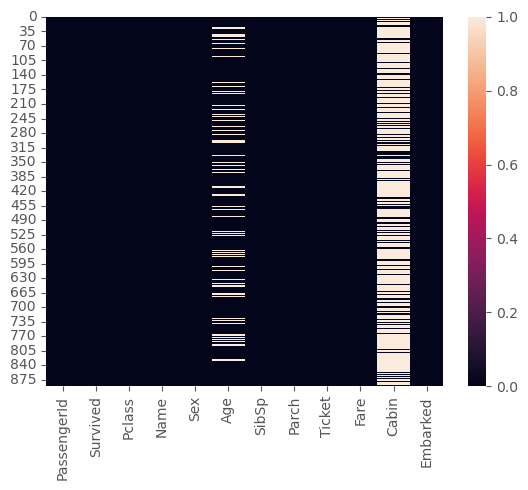

In [18]:
sns.heatmap(df_train.isnull())

<mark>Results

- PassengerId is completely unique. It must be dropped
- Cabin has many nan values. It can be dropped after analysis.
- Age has nan values. It can be filled with some techniques. 
- Embarked has two nan values. It will be filled. 
- Missing values don't seem related. (According to heatmap)

## Checking Missing Values in both set

In [19]:
na_df = pd.DataFrame(df_train.drop('Survived',axis=1).isna().sum(),columns=['Train_Na_Sum'])
na_df['Test_Na_Sum'] = df_test.isna().sum()
display(na_df)
print('Number of Na of Survived (Target) in Train',df_train['Survived'].isna().sum())

Train_Na_Sum  Test_Na_Sum
PassengerId             0            0
Pclass                  0            0
Name                    0            0
Sex                     0            0
Age                   177           86
SibSp                   0            0
Parch                   0            0
Ticket                  0            0
Fare                    0            1
Cabin                 687          327
Embarked                2            0

Number of Na of Survived (Target) in Train 0


Observations:
- Test set have many NaN values in Cabin and Age and only one NaN in fare

## Feature Distribution and Univariate Outlier Visualization

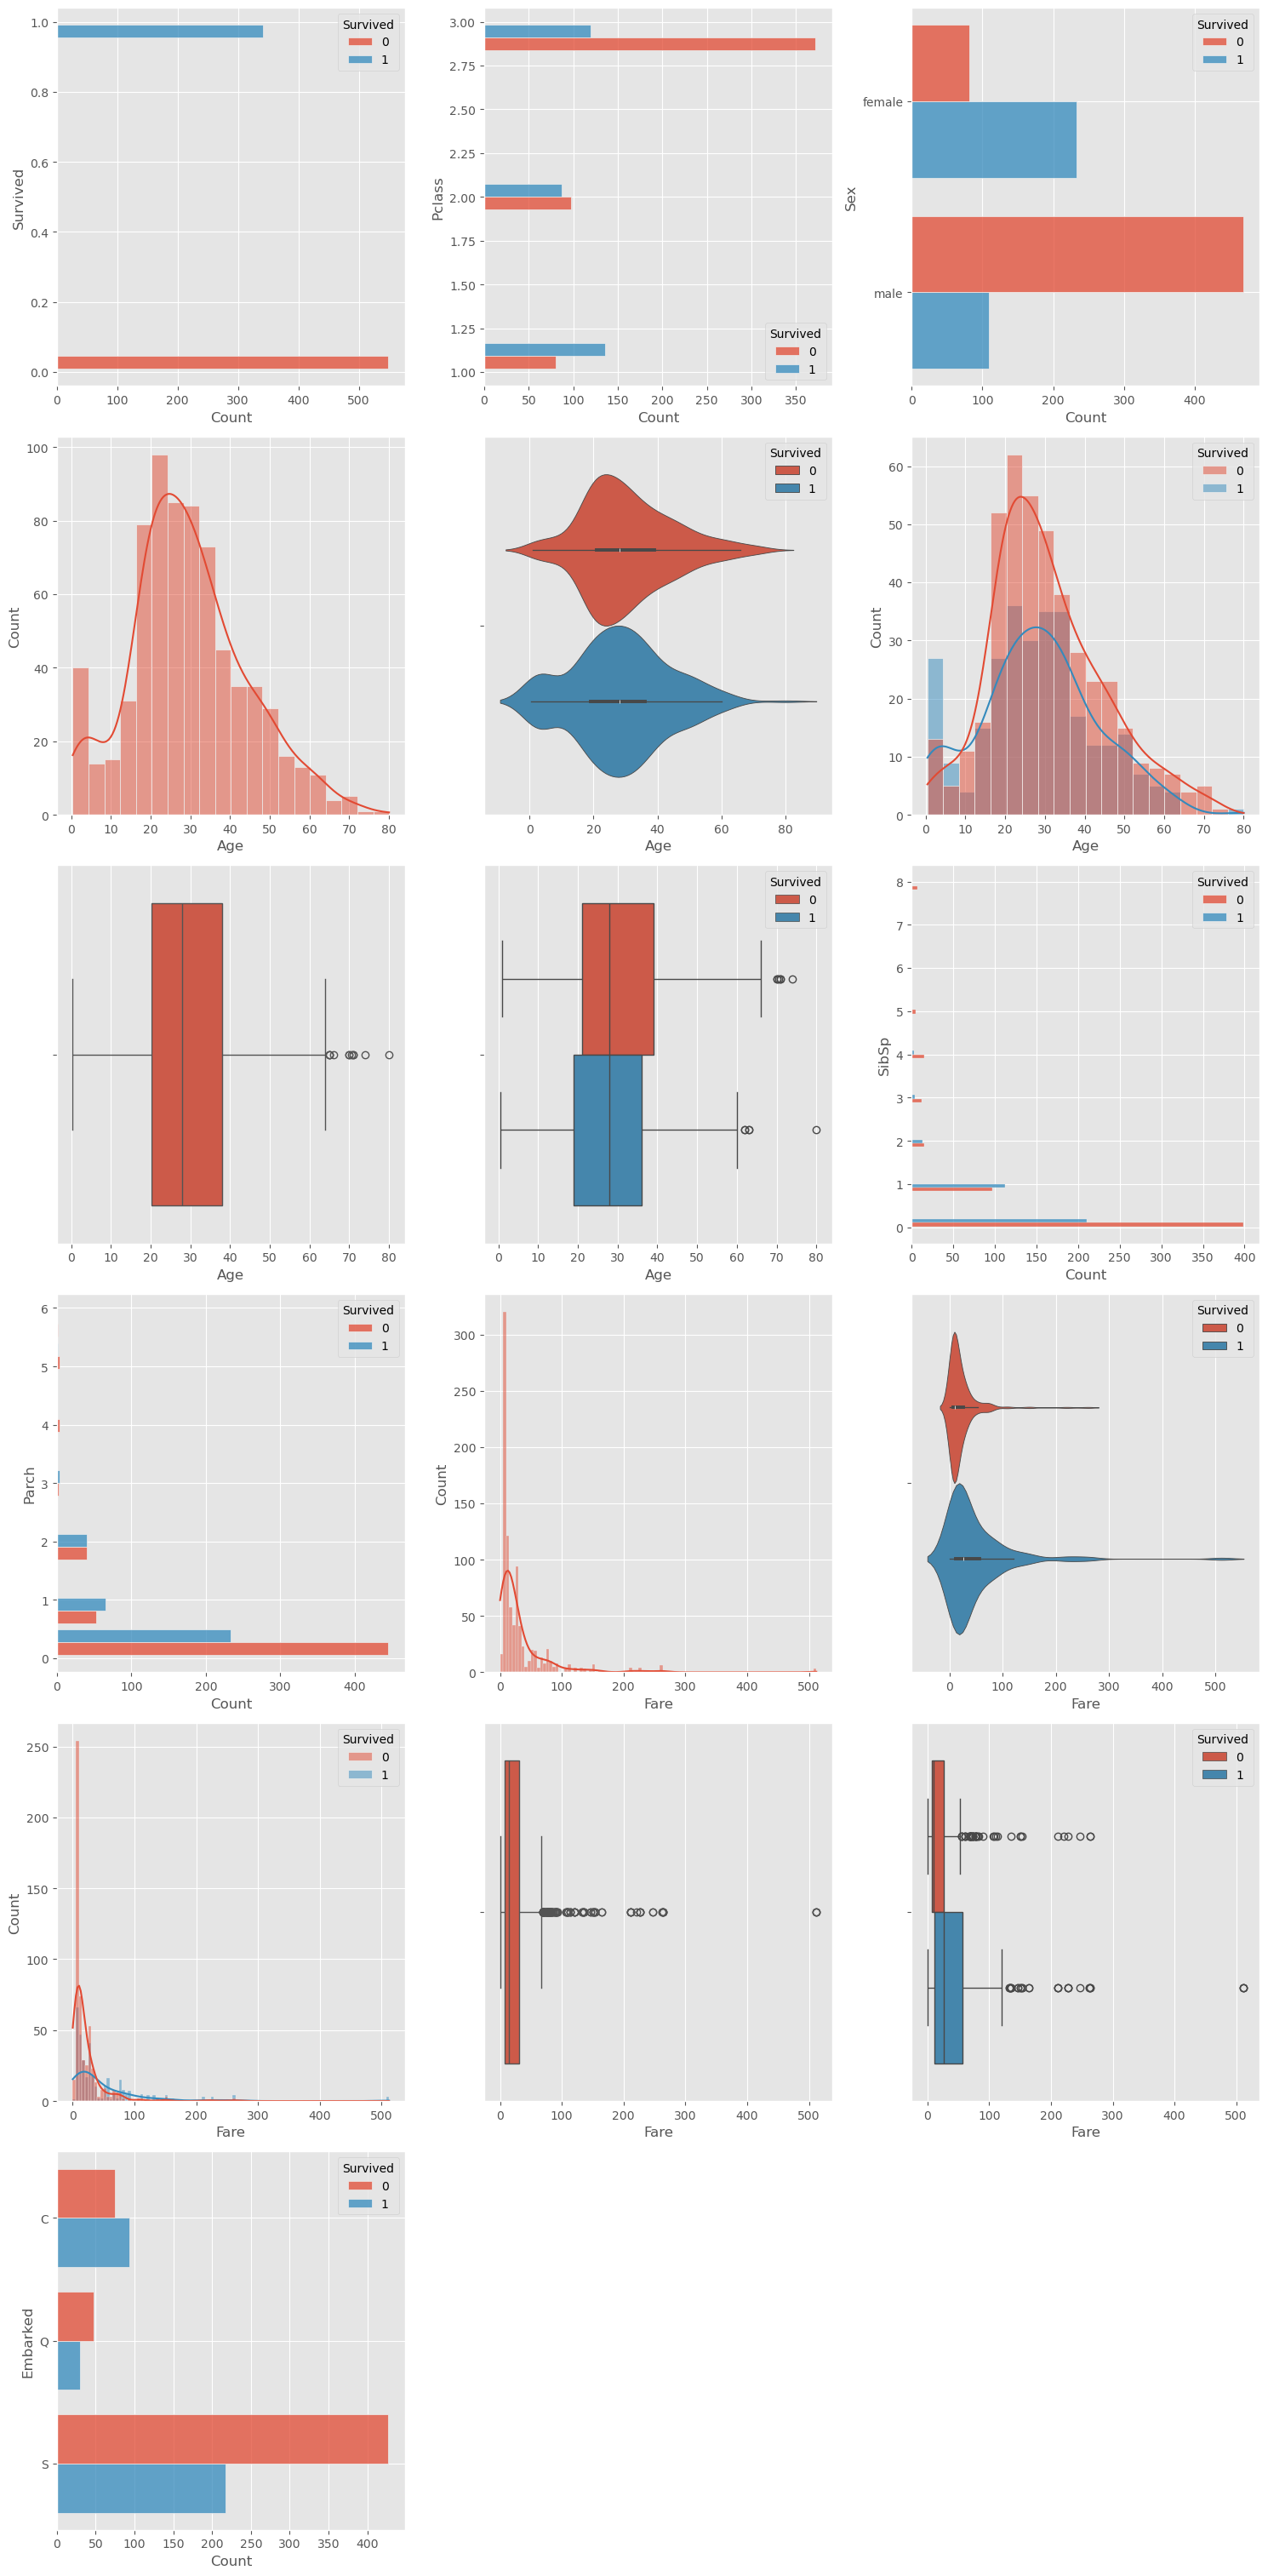

In [168]:
feature_distr(df_train,'Survived')

In [18]:
important_vars = ['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked','Survived']

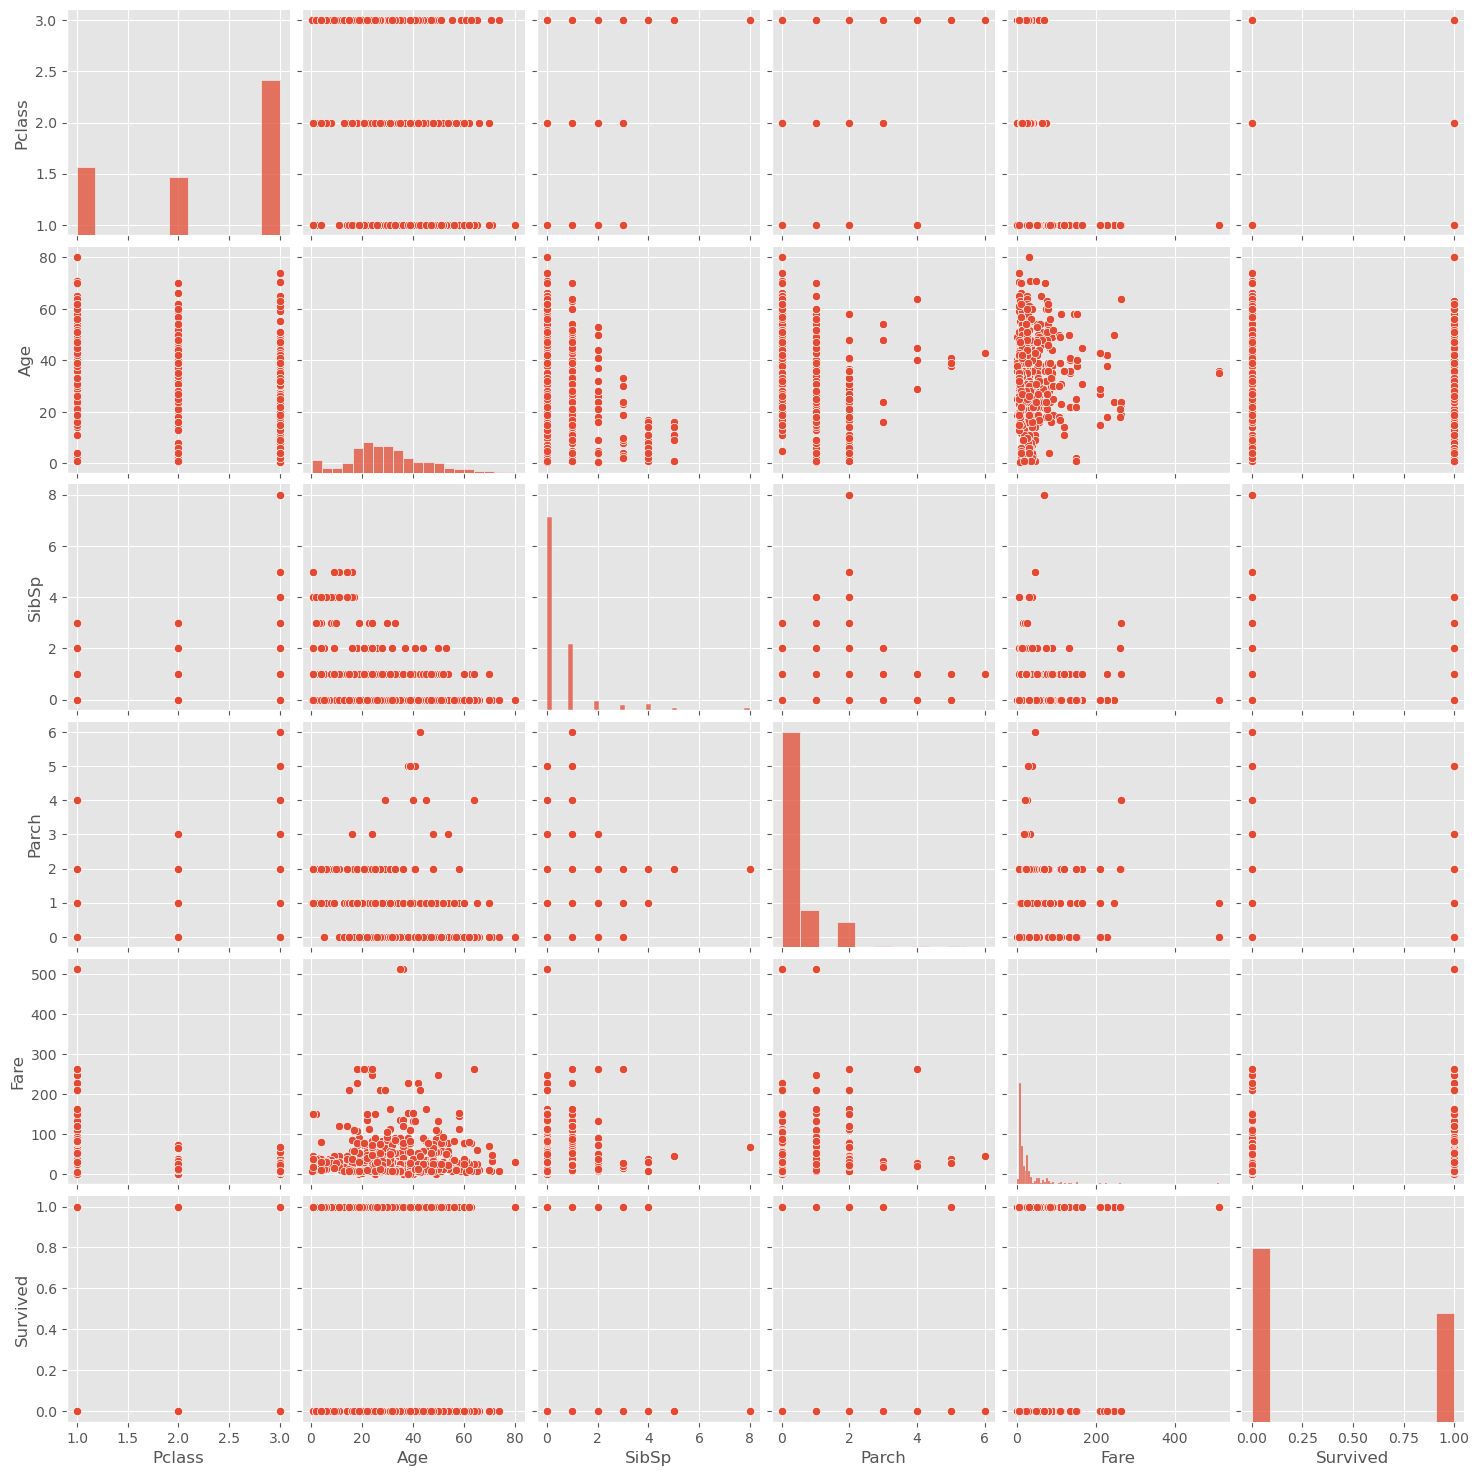

In [19]:
sns.pairplot(df_train[important_vars],)

## Statistical Measurement to understand relationship between features

**<mark style=" background-color:yellow ; color:black; " >I'm not taking unique features and problematic features required encode. If i can transform them any useful shape, I will repeat this step and EDA**

In [20]:
imp_vars= ['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare',  'Sex', 'Embarked']
full_num = OrdinalEncoder(cols=['Sex','Embarked']).fit_transform(df_train.drop('Survived',axis=1),df_train['Survived'])
full_num['Survived']= df_train['Survived']

In [74]:
full_num[imp_vars].corr(method='pearson')

Survived    Pclass       Age     SibSp     Parch      Fare  \
Survived  1.000000 -0.338481 -0.077221 -0.035322  0.081629  0.257482   
Pclass   -0.338481  1.000000 -0.369226  0.083081  0.018443 -0.550553   
Age      -0.077221 -0.369226  1.000000 -0.308247 -0.189119  0.096284   
SibSp    -0.035322  0.083081 -0.308247  1.000000  0.414838  0.159506   
Parch     0.081629  0.018443 -0.189119  0.414838  1.000000  0.216252   
Fare      0.257482 -0.550553  0.096284  0.159506  0.216252  1.000000   
Sex       0.543351 -0.131900 -0.093254  0.114631  0.245489  0.182331   
Embarked  0.118026  0.028566  0.031556 -0.063794 -0.082144  0.070034   

               Sex  Embarked  
Survived  0.543351  0.118026  
Pclass   -0.131900  0.028566  
Age      -0.093254  0.031556  
SibSp     0.114631 -0.063794  
Parch     0.245489 -0.082144  
Fare      0.182331  0.070034  
Sex       1.000000  0.128526  
Embarked  0.128526  1.000000

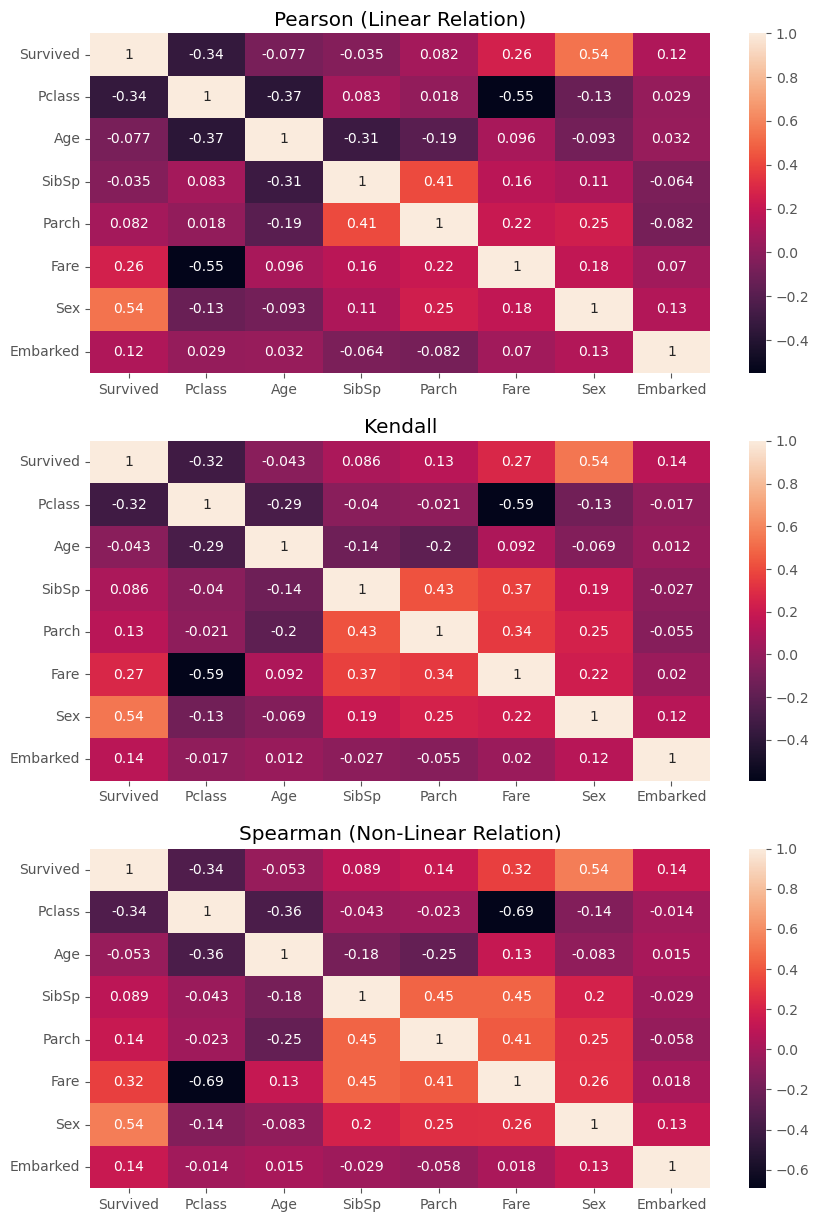

In [433]:
display_corr(full_num,imp_vars)

In [75]:
from sklearn.feature_selection import mutual_info_classif

In [81]:
clear_indexes=full_num[imp_vars].dropna().index

In [306]:
mutualInfo = pd.Series(mutual_info_classif(full_num[imp_vars].dropna(),y=full_num['Survived'].iloc[clear_indexes],random_state=42))
mutualInfo.index = imp_vars
mutualInfo.sort_values(ascending=False)

Survived    0.676132
Sex         0.164491
Pclass      0.077556
Fare        0.074552
Parch       0.042989
Age         0.025231
SibSp       0.023403
Embarked    0.004664
dtype: float64

**<mark style=" background-color:yellow ; color:black; " >Results**

- 'Sex' is most correlated feature with Target Feature
- 'Pclass' is second but inverse correlated
- 'Fare' is third
  
MultiCollinearity

- Pclass and Fare seems inverse correlated. Attention to medium realation (Linear-NonLinear)
- Pclass and Age are little inverse correlated. Attention to relation ()
- Age and Sibsp are little correlated. Attention to relation
- Parch and Sibsp are little correlated. Attention to medium realation (Linear-NonLinear)
- Fare and Sibsp+Parch are little correlated.Attention to medium realation (Only NonLinear)

Try to understand relation between features with these correlations

## Feature Content Analysis

**<mark style=" background-color:yellow ; color:black; " >In this step, I am trying to find useful info about features who from EDA that I can't find any useful information about them. If it is not possible to save, I will drop them**

In [68]:
full_num = OrdinalEncoder(cols=['Sex','Embarked']).fit_transform(df_train.drop('Survived',axis=1),df_train['Survived'])
full_num['Survived']= df_train['Survived']
df_engineering = full_num.copy()

### PassengerId

**<mark style=" background-color:yellow ; color:black; " >I analysed the PassengerId feature in the early stages and decided it was unnecessary. Because it is completely unique. It will be dropped in Feature Engineering step**

### Ticket

In [24]:
df_engineering['Ticket'].str.split(' ')

0             [A/5, 21171]
1              [PC, 17599]
2      [STON/O2., 3101282]
3                 [113803]
4                 [373450]
              ...         
886               [211536]
887               [112053]
888          [W./C., 6607]
889               [111369]
890               [370376]
Name: Ticket, Length: 891, dtype: object

**<mark style=" background-color:yellow ; color:black; " > It seems, I can convert ticket column to only numerical values. I will try it in Feature Engineering Step**

### Cabin

In [464]:
df_train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [449]:
df_engineering['Cabin'].isna().mean()

0.7710437710437711

**<mark style=" background-color:yellow ; color:black; " >77% of Cabin is NaN. It will most probably be dropped. But before dropping it i should check is Cabin has any useful information**

In [25]:
# Nunique and number of Not Null instance
df_engineering['Cabin'].dropna().nunique(),df_engineering['Cabin'].dropna().shape

(147, (204,))

In [458]:
basicEDA(df_engineering[['Cabin','Survived']].dropna())




====BASIC EDA==== 



 /////////////// Survived ///////////////


Type  Na_number  Na_percentage  Nunique  Duplicated_in_column  \
Survived  discrete          0            0.0        2                   204   

          Number_of_duplicated_rows  mode  median  
Survived                         41     1     1.0



Unique values:
 [1 0]


 /////////////// Cabin ///////////////


Type  Na_number  Na_percentage  Nunique  Duplicated_in_column  \
Cabin  categorical           0            0.0      147                   103   

       Number_of_duplicated_rows     mode  
Cabin                         41  B96 B98

Unique values cutted early(0:200):
 ['C85' 'C123' 'E46' 'G6' 'C103' 'D56' 'A6' 'C23 C25 C27' 'B78' 'D33' 'B30'
 'C52' 'B28' 'C83' 'F33' 'F G73' 'E31' 'A5' 'D10 D12' 'D26' 'C110'
 'B58 B60' 'E101' 'F E69' 'D47' 'B86' 'F2' 'C2' 'E33' 'B19' 'A7' 'C49'
 'F4' 'A32' 'B4' 'B80' 'A31' 'D36' 'D15' 'C93' 'C78' 'D35' 'C87' 'B77'
 'E67' 'B94' 'C125' 'C99' 'C118' 'D7' 'A19' 'B49' 'D' 'C22 C26' 'C106'
 'C65' 'E36' 'C54' 'B57 B59 B63 B66' 'C7' 'E34' 'C32' 'B18' 'C124' 'C91'
 'E40' 'T' 'C128' 'D37' 'B35' 'E50' 'C82' 'B96 B98' 'E10' 'E44' 'A34'
 'C104' 'C111' 'C92' 'E38' 'D21' 'E12' 'E63' 'A14' 'B37' 'C30' 'D20' 'B79'
 'E25' 'D46' 'B73' 'C95' 'B38' 'B39' 'B22' 'C86' 'C70' 'A16' 'C101' 'C68'
 'A10' 'E68' 'B41' 'A20' 'D19' 'D50' 'D9' 'A23' 'B50' 'A26' 'D48' 'E58'
 'C126' 'B71' 'B51 B53 B55' 'D49' 'B5' 'B20' 'F G63' 'C62 C64' 'E24' 'C90'
 'C45' 'E8' 'B101' 'D45' 'C46' 'D30' 'E121' 'D11' 'E77' 'F38' 'B3' 'D6'
 'B82 B84' 'D17' 'A36' 'B102' 'B69' 'E49' 'C47' 'D28' 'E17' 'A24' 'C50'
 'B42' 'C148']


Variables

In [41]:
# Cabin what contain F don't have only F
df_engineering.Cabin.dropna()[df_engineering['Cabin'].dropna().str.contains('F')]

66       F33
75     F G73
128    F E69
148       F2
183       F4
193       F2
340       F2
345      F33
516      F33
618       F4
699    F G63
715    F G73
776      F38
Name: Cabin, dtype: object

In [48]:
df_engineering['Cabin'].dropna().str.replace(r'[^a-zA-z]','',regex=True).unique()

array(['C', 'E', 'G', 'D', 'A', 'CCC', 'B', 'F', 'FG', 'DD', 'BB', 'FE',
       'CC', 'BBBB', 'T', 'BBB'], dtype=object)

In [39]:
df_engineering['Cabin'].dropna().str.replace(r'[^a-zA-z]','',regex=True).str[0].unique()

array(['C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

In [96]:
df_trial = df_train.copy()
df_trial['Cabin'] = df_trial['Cabin'].dropna().str.replace(r'[^a-zA-z]','',regex=True).str[0]

In [75]:
df_train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

<mark>If cells have 100% probability it can be useful for us

In [74]:
df_trial[~df_trial.Cabin.isna()].groupby(by=['Sex','Cabin'])['Survived'].mean().unstack()

Cabin          A    B         C         D         E      F    G    T
Sex                                                                 
female  1.000000  1.0  0.888889  1.000000  0.933333  1.000  0.5  NaN
male    0.428571  0.4  0.343750  0.466667  0.588235  0.375  NaN  0.0

In [109]:
df_trial[((df_trial['Sex'] == 'female') & (df_trial['Cabin']=='A')) | ((df_trial['Sex'] == 'female') & (df_trial['Cabin']=='B')) | ((df_trial['Sex'] == 'female') & (df_trial['Cabin']=='F')) |((df_trial['Sex'] == 'female') & (df_trial['Cabin']=='B')) ].sort_values(by=['Ticket'])

PassengerId  Survived  Pclass  \
128          129         1       3   
540          541         1       1   
556          557         1       1   
291          292         1       1   
520          521         1       1   
820          821         1       1   
539          540         1       1   
781          782         1       1   
641          642         1       1   
369          370         1       1   
299          300         1       1   
31            32         1       1   
195          196         1       1   
311          312         1       1   
742          743         1       1   
194          195         1       1   
779          780         1       1   
730          731         1       1   
689          690         1       1   
66            67         1       2   
516          517         1       2   
504          505         1       1   
759          760         1       1   
257          258         1       1   
329          330         1       1   
523          524         1       1   
887          888         1       1   
829          830         1       1   
61            62         1       1   
763          764         1       1   
435          436         1       1   
618          619         1       2   
345          346         1       2   

                                                  Name     Sex   Age  SibSp  \
128                                  Peter, Miss. Anna  female   NaN      1   
540                            Crosby, Miss. Harriet R  female  36.0      0   
556  Duff Gordon, Lady. (Lucille Christiana Sutherl...  female  48.0      1   
291            Bishop, Mrs. Dickinson H (Helen Walton)  female  19.0      1   
520                              Perreault, Miss. Anne  female  30.0      0   
820  Hays, Mrs. Charles Melville (Clara Jennings Gr...  female  52.0      1   
539                 Frolicher, Miss. Hedwig Margaritha  female  22.0      0   
781          Dick, Mrs. Albert Adrian (Vera Gillespie)  female  17.0      1   
641                               Sagesser, Mlle. Emma  female  24.0      0   
369                      Aubart, Mme. Leontine Pauline  female  24.0      0   
299    Baxter, Mrs. James (Helene DeLaudeniere Chaput)  female  50.0      0   
31      Spencer, Mrs. William Augustus (Marie Eugenie)  female   NaN      1   
195                               Lurette, Miss. Elise  female  58.0      0   
311                         Ryerson, Miss. Emily Borie  female  18.0      2   
742              Ryerson, Miss. Susan Parker "Suzette"  female  21.0      2   
194          Brown, Mrs. James Joseph (Margaret Tobin)  female  44.0      0   
779  Robert, Mrs. Edward Scott (Elisabeth Walton Mc...  female  43.0      0   
730                      Allen, Miss. Elisabeth Walton  female  29.0      0   
689                  Madill, Miss. Georgette Alexandra  female  15.0      0   
66                        Nye, Mrs. (Elizabeth Ramell)  female  29.0      0   
516                       Lemore, Mrs. (Amelia Milley)  female  34.0      0   
504                              Maioni, Miss. Roberta  female  16.0      0   
759  Rothes, the Countess. of (Lucy Noel Martha Dye...  female  33.0      0   
257                               Cherry, Miss. Gladys  female  30.0      0   
329                       Hippach, Miss. Jean Gertrude  female  16.0      0   
523    Hippach, Mrs. Louis Albert (Ida Sophia Fischer)  female  44.0      0   
887                       Graham, Miss. Margaret Edith  female  19.0      0   
829          Stone, Mrs. George Nelson (Martha Evelyn)  female  62.0      0   
61                                 Icard, Miss. Amelie  female  38.0      0   
763          Carter, Mrs. William Ernest (Lucile Polk)  female  36.0      1   
435                          Carter, Miss. Lucile Polk  female  14.0      1   
618                        Becker, Miss. Marion Louise  female   4.0      2   
345                      Brown, Miss. Amelia "Mildred"  female  24.0      0   

     Parch  Ticket  Fare 

In [76]:
df_trial[~df_trial.Cabin.isna()].groupby(by=['Pclass','Cabin'])['Survived'].mean().unstack()

Cabin          A         B        C         D     E      F    G    T
Pclass                                                              
1       0.466667  0.744681  0.59322  0.758621  0.72    NaN  NaN  0.0
2            NaN       NaN      NaN  0.750000  0.75  0.875  NaN  NaN
3            NaN       NaN      NaN       NaN  1.00  0.200  0.5  NaN

In [80]:
df_trial[(df_trial['Pclass']==3) & (df_trial['Cabin']=='E')]

PassengerId  Survived  Pclass                                Name  \
429          430         1       3  Pickard, Mr. Berk (Berk Trembisky)   
751          752         1       3                 Moor, Master. Meier   
823          824         1       3                  Moor, Mrs. (Beila)   

        Sex   Age  SibSp  Parch             Ticket  Fare Cabin Embarked  
429    male  32.0      0      0  SOTON/O.Q. 392078     8     E        S  
751    male   6.0      0      1             392096    12     E        S  
823  female  27.0      0      1             392096    12     E        S

In [115]:
df_trial[~df_trial.Cabin.isna()].groupby(by=['SibSp','Cabin'])['Survived'].mean().unstack()

Cabin         A         B         C         D         E      F    G    T
SibSp                                                                   
0      0.384615  0.687500  0.586207  0.631579  0.772727  0.375  0.5  0.0
1      1.000000  0.846154  0.600000  0.928571  0.700000  1.000  0.5  NaN
2           NaN  1.000000  0.500000       NaN       NaN  1.000  NaN  NaN
3           NaN       NaN  0.666667       NaN       NaN    NaN  NaN  NaN

In [116]:
df_trial[~df_trial.Cabin.isna()].groupby(by=['Parch','Cabin'])['Survived'].mean().unstack()

Cabin         A         B         C         D         E         F         G  \
Parch                                                                         
0      0.428571  0.678571  0.627907  0.800000  0.695652  0.428571       NaN   
1           NaN  0.727273  0.500000  0.666667  0.875000  1.000000  0.333333   
2      1.000000  1.000000  0.555556  0.500000  1.000000  0.000000  1.000000   
4           NaN       NaN  0.000000       NaN       NaN       NaN       NaN   

Cabin    T  
Parch       
0      0.0  
1      NaN  
2      NaN  
4      NaN

In [118]:
df_trial[~df_trial.Cabin.isna()].groupby(by=['Embarked','Cabin'])['Survived'].mean().unstack()

Cabin            A         B         C         D         E         F    G    T
Embarked                                                                      
C         0.571429  0.772727  0.666667  0.846154  1.000000  1.000000  NaN  NaN
Q              NaN       NaN  0.500000       NaN  1.000000  0.000000  NaN  NaN
S         0.375000  0.695652  0.555556  0.700000  0.692308  0.636364  0.5  0.0

In [125]:
df_trial[~df_trial.Cabin.isna()].groupby(by=['Embarked','Cabin'])['Cabin'].count().unstack()

Cabin     A   B   C   D   E   F  G  T
Embarked                             
C         7  22  21  13   5   1  0  0
Q         0   0   2   0   1   1  0  0
S         8  23  36  20  26  11  4  1

**<mark>Results**

- When i looking for Cabin, i found that if ticket numbers are same they have same surname and they are a family. I can fill NaN tickets with that info. Same surnames have same ticket number !!

- I tried to use only letters of Cabin but Cabin has so many NaN values so it doesn't make sense . i will drop it

### Name

In [127]:
basicEDA(df_engineering[['Survived','Name']])




====BASIC EDA==== 



 /////////////// Survived ///////////////


Type  Na_number  Na_percentage  Nunique  Duplicated_in_column  \
Survived  discrete          0            0.0        2                   891   

          Number_of_duplicated_rows  mode  median  
Survived                          0     0     0.0



Unique values:
 [0 1]


 /////////////// Name ///////////////


Type  Na_number  Na_percentage  Nunique  Duplicated_in_column  \
Name  categorical           0            0.0      891                     0   

      Number_of_duplicated_rows                 mode  
Name                          0  Abbing, Mr. Anthony

Unique values cutted early(0:200):
 ['Braund, Mr. Owen Harris'
 'Cumings, Mrs. John Bradley (Florence Briggs Thayer)'
 'Heikkinen, Miss. Laina' 'Futrelle, Mrs. Jacques Heath (Lily May Peel)'
 'Allen, Mr. William Henry' 'Moran, Mr. James' 'McCarthy, Mr. Timothy J'
 'Palsson, Master. Gosta Leonard'
 'Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)'
 'Nasser, Mrs. Nicholas (Adele Achem)' 'Sandstrom, Miss. Marguerite Rut'
 'Bonnell, Miss. Elizabeth' 'Saundercock, Mr. William Henry'
 'Andersson, Mr. Anders Johan' 'Vestrom, Miss. Hulda Amanda Adolfina'
 'Hewlett, Mrs. (Mary D Kingcome) ' 'Rice, Master. Eugene'
 'Williams, Mr. Charles Eugene'
 'Vander Planke, Mrs. Julius (Emelia Maria Vandemoortele)'
 'Masselmani, Mrs. Fatima' 'Fynney, Mr. Joseph J' 'Beesley, Mr. Lawrence'
 'McGowan, Miss. Anna "Annie"' 'Sloper, Mr. William Thompson'
 'Palsson, Miss. Torborg Danira'
 'Asplund, Mrs. Carl Oscar (Selma Augusta Emilia Johansson)'
 'Emir, Mr. Farred Chehab' 'Fortune, Mr. Charles Alexander'
 'O\'

In [132]:
#Surnames
df_engineering['Name'].str.split(',').str[0].nunique()

667

In [137]:
#Titles
df_engineering['Name'].str.split(',').str[1].str.split('.').str[0].unique()

array([' Mr', ' Mrs', ' Miss', ' Master', ' Don', ' Rev', ' Dr', ' Mme',
       ' Ms', ' Major', ' Lady', ' Sir', ' Mlle', ' Col', ' Capt',
       ' the Countess', ' Jonkheer'], dtype=object)

**<mark>Results**

- Name contains Surname too. So I will create surname column.
- If surnames are same they are family. Also i can check it with their Ticket number too. If their ticket numbers are same they are family too. If Ticket numbers and Surnames are same they are family.(Binary Feature,Has_family)
- (New Feature) I will create Family_Size feature with Ticket Number and Has_family
- (New Feature) Family Size
- Name contains Title too. (Miss,Mrs,Mr, Master etc.)
- Name is completely unique. So, after Feature Engineering, i will drop it

### Age

<mark> Note

Binning the Age feature can be useful. I will try it on FE step

# Feature Engineering

### Encoding

In [31]:
oe =  OrdinalEncoder(cols=['Sex','Embarked'])

In [32]:
full_num =oe.fit_transform(df_train.drop('Survived',axis=1),df_train['Survived'])
full_num['Survived']= df_train['Survived']
df_engineering = full_num.copy()

In [33]:
oe.category_mapping

[{'col': 'Sex',
  'mapping': male      1
  female    2
  NaN      -2
  dtype: int64,
  'data_type': CategoricalDtype(categories=['female', 'male'], ordered=False, categories_dtype=object)},
 {'col': 'Embarked',
  'mapping': S      1
  C      2
  Q      3
  NaN    4
  dtype: int64,
  'data_type': CategoricalDtype(categories=['C', 'Q', 'S'], ordered=False, categories_dtype=object)}]

Sex=> Male 1 , female 2

Embarked=> S 1, C 2, Q 3

### PassengerId

In [34]:
df_engineering.drop(columns=['PassengerId'],axis=1,inplace=True)

### Ticket

<mark>I'm converting Ticket to only numbers

In [35]:
df_engineering['Ticket'] = df_engineering['Ticket'].str.split(' ').apply(lambda x: x[1] if len(x)>1  else x[0]).str.replace(r'[^\d\s]','',regex=True)
#df_engineering['Ticket'] = df_engineering['Ticket'].str.replace(r'[^\d\s]','',regex=True)

In [36]:
df_engineering.loc[df_engineering['Ticket']=='','Ticket'] = 0
df_engineering['Ticket'] = df_engineering['Ticket'].astype('uint32')

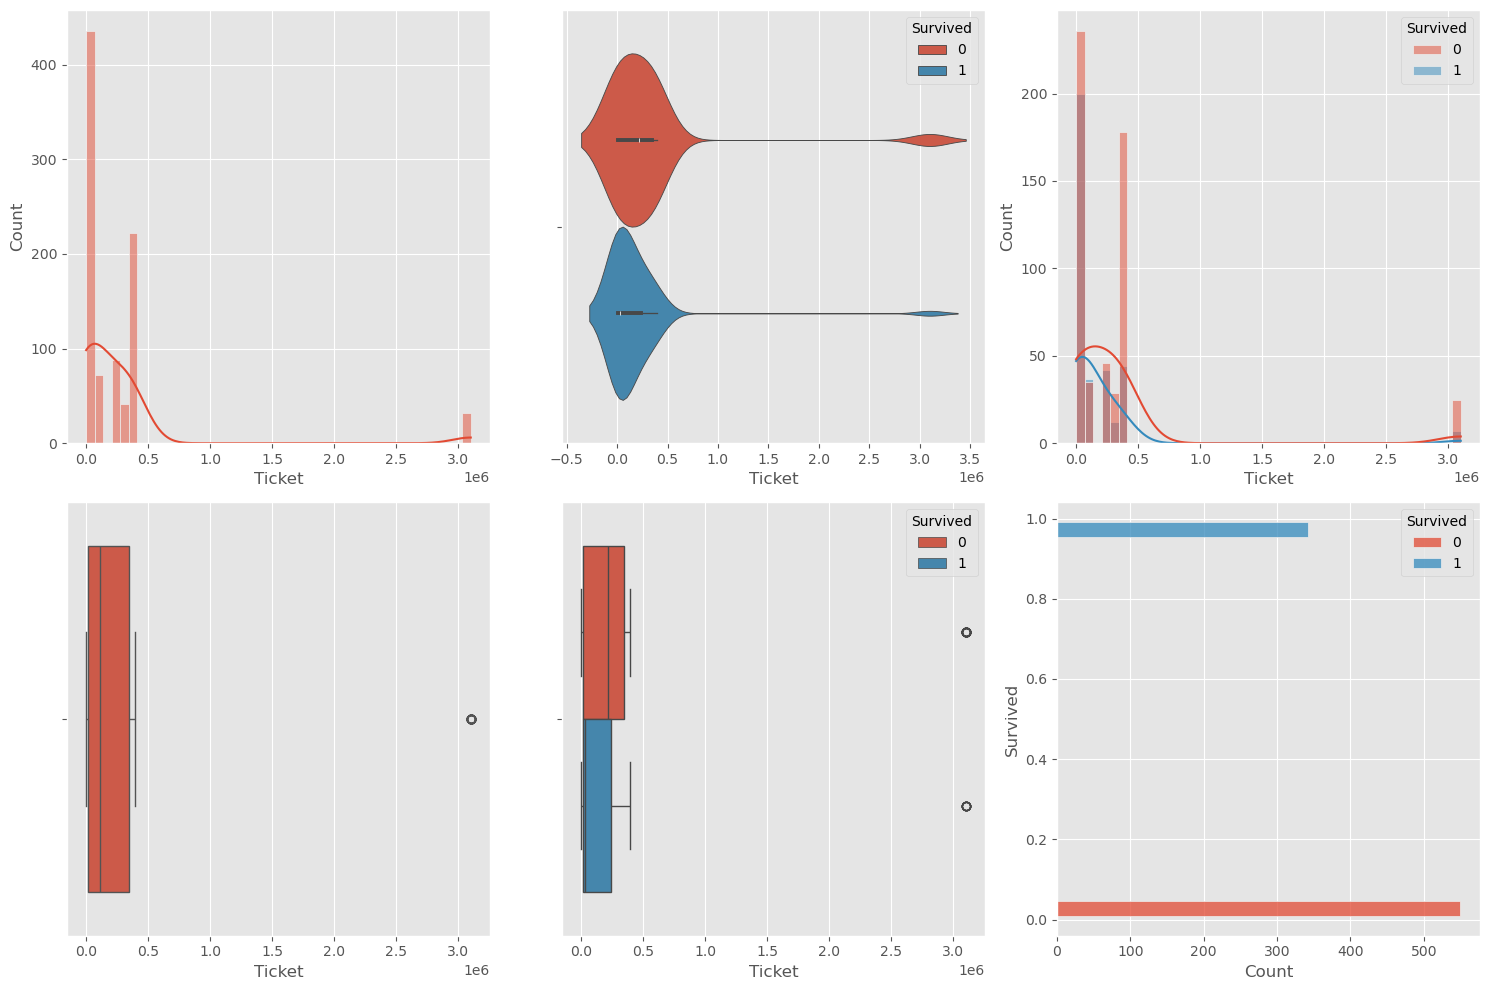

In [37]:
feature_distr(df_engineering[['Ticket','Survived']],'Survived')

In [38]:
prep_vars = ['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex', 'Embarked', 'Ticket']

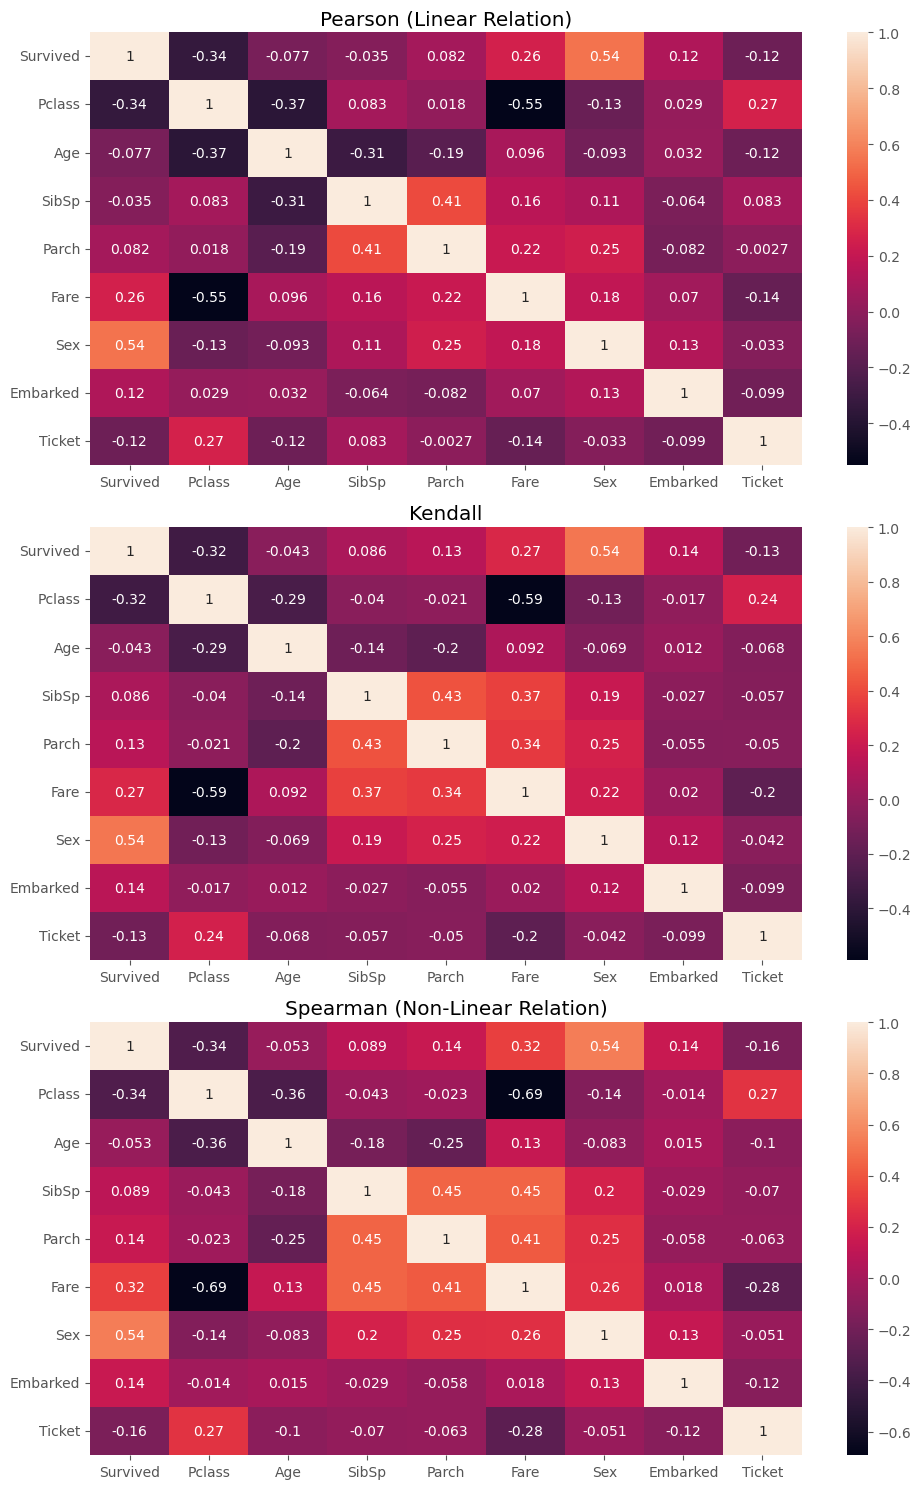

In [39]:
display_corr(df_engineering,prep_vars)

<Axes: xlabel='Ticket', ylabel='Pclass'>

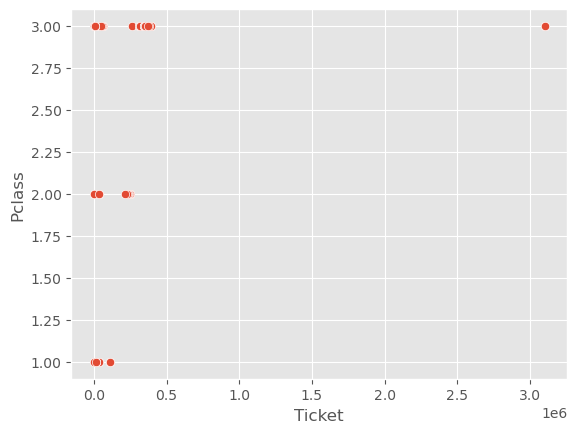

In [40]:
sns.scatterplot(data=df_engineering,x='Ticket',y='Pclass')

In [41]:
df_engineering.sort_values(by='Ticket')[['Ticket','Pclass','Fare']]

Ticket  Pclass  Fare
179        0       3     0
473        0       2    13
597        0       3     0
302        0       3     0
271        0       3     0
..       ...     ...   ...
363  3101310       3     7
210  3101311       3     7
784  3101312       3     7
511  3101316       3     8
491  3101317       3     7

[891 rows x 3 columns]

In [42]:
#Ticket 0 represents the missing values
#Same Ticket numbers have same pclass
ticket_pclass = df_engineering.sort_values(by='Ticket').groupby(['Ticket'])['Pclass'].agg(['mean', 'sum', 'min', 'max', 'std','count'])
display (ticket_pclass[(ticket_pclass['count']>1) & (ticket_pclass['std']!=0)],ticket_pclass[(ticket_pclass['count']>1) & (ticket_pclass['std']==0)])

mean  sum  min  max       std  count
Ticket                                      
0        2.8   14    2    3  0.447214      5
751      2.5    5    2    3  0.707107      2

mean  sum  min  max  std  count
Ticket                                  
2         3.0   36    3    3  0.0     12
3         2.0    4    2    2  0.0      2
1601      3.0   21    3    3  0.0      7
2079      2.0    4    2    2  0.0      2
2123      2.0    6    2    2  0.0      3
...       ...  ...  ...  ...  ...    ...
382652    3.0   15    3    3  0.0      5
392096    3.0    6    3    3  0.0      2
3101278   3.0    6    3    3  0.0      2
3101279   3.0    6    3    3  0.0      2
3101295   3.0   18    3    3  0.0      6

[134 rows x 6 columns]

In [43]:
#Ticket 0 represents the missing values
#Same Ticket numbers have same fare
ticket_fare = df_engineering.sort_values(by='Ticket').groupby(['Ticket'])['Fare'].agg(['mean', 'sum', 'min', 'max', 'std','count'])
display (ticket_fare[(ticket_fare['count']>1) & (ticket_fare['std']!=0)],ticket_fare[(ticket_fare['count']>1) & (ticket_fare['std']==0)])

mean  sum  min  max        std  count
Ticket                                            
0        2.600000   13    0   13   5.813777      5
751      8.500000   17    7   10   2.121320      2
17474   46.666667  140   26   57  17.897858      3

mean  sum  min  max  std  count
Ticket                                  
2         7.0   84    7    7  0.0     12
3        10.0   20   10   10  0.0      2
1601     56.0  392   56   56  0.0      7
2079     37.0   74   37   37  0.0      2
2123     41.0  123   41   41  0.0      3
...       ...  ...  ...  ...  ...    ...
382652   29.0  145   29   29  0.0      5
392096   12.0   24   12   12  0.0      2
3101278  15.0   30   15   15  0.0      2
3101279  15.0   30   15   15  0.0      2
3101295  39.0  234   39   39  0.0      6

[133 rows x 6 columns]

In [44]:
df_engineering[['Ticket','Cabin']].dropna().sort_values(by='Ticket')

Ticket        Cabin
473       0            D
772       3          E77
872     695  B51 B53 B55
292    2163            D
128    2668        F E69
..      ...          ...
715  348124        F G73
776  383121          F38
429  392078          E10
823  392096         E121
751  392096         E121

[204 rows x 2 columns]

In [45]:
from sklearn.feature_selection import mutual_info_classif
imp_vars= ['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare',  'Sex', 'Embarked','Ticket']
clear_indexes=df_engineering[imp_vars].dropna().index

In [46]:
mutualInfo = pd.Series(mutual_info_classif(df_engineering[imp_vars].dropna(),y=df_engineering['Survived'].iloc[clear_indexes]))
mutualInfo.index = imp_vars
mutualInfo.sort_values(ascending=False)

Survived    0.676132
Sex         0.155040
Ticket      0.113072
Pclass      0.075510
Fare        0.072539
Parch       0.028484
SibSp       0.023796
Age         0.015007
Embarked    0.000000
dtype: float64

<Mark>EDA Results

These visualizations and EDA steps were only for Ticket. 

-Relation of Ticket with Pclass and Fare should be analysed (Linear-Pclass, NonLinear-Fare)
    
    -Ticket&Pclass => Mostly(>%99), Same ticket number means same Pclass

    -Ticket&Fare => Mostly(>%99), Same ticket number means same Fare

-Cabin and ticket have relation only if the surnames are same. So Cabin has no reason to exist.

-If Ticket didn't have a high information gain, I would drop it



### Cabin

In [47]:
df_engineering['Cabin'] = df_engineering['Cabin'].dropna().str.replace(r'[^a-zA-z]','',regex=True).str[0]

In [48]:
basicEDA(df_engineering[['Cabin','Survived']])




====BASIC EDA==== 



 /////////////// Survived ///////////////


Type  Na_number  Na_percentage  Nunique  Duplicated_in_column  \
Survived  discrete          0            0.0        2                   891   

          Number_of_duplicated_rows  mode  median  
Survived                        874     0     0.0

Survived    0    1
count     549  342



Unique values:
 [0 1]


 /////////////// Cabin ///////////////


Type  Na_number  Na_percentage  Nunique  Duplicated_in_column  \
Cabin  categorical         687      77.104377        8                   890   

       Number_of_duplicated_rows mode  
Cabin                        874    C

Cabin   C   B   D   E   A   F  G  T
count  59  47  33  32  15  13  4  1



Unique values:
 [nan 'C' 'E' 'G' 'D' 'A' 'B' 'F' 'T']


Variables and their types on table

Number of numerical variables => 1 
Numerical Variables=> ['Survived']
Number of continuous variables => 0 
Continuous Variables=> []
Number of discrete variables => 1 
Discrete Variables=> ['Survived']
Number of categorical variables => 1 
Categorical Variables=> ['Cabin']


<Axes: xlabel='Count', ylabel='Cabin'>

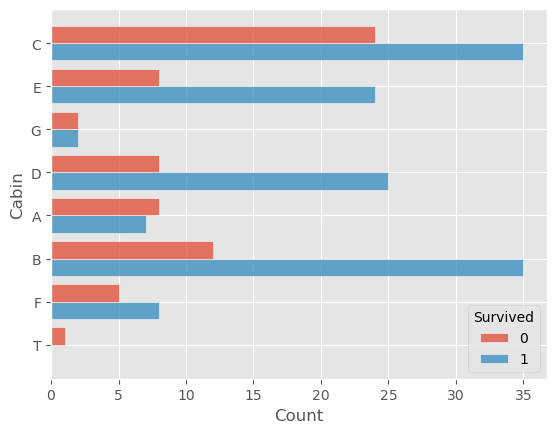

In [49]:
sns.histplot(data=df_engineering,y='Cabin',hue='Survived',multiple='dodge',shrink=0.8)

In [50]:
mapping_list = {
    'A':1,
    'B':2,
    'C':3,
    'D':4,
    'E':5,
    'F':6,
    'G':7,
    'T':8,
    'NaN':9,
}

df_engineering['Cabin'] = df_engineering['Cabin'].map(mapping_list)

In [51]:
prep_vars = ['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex', 'Embarked', 'Ticket','Cabin']

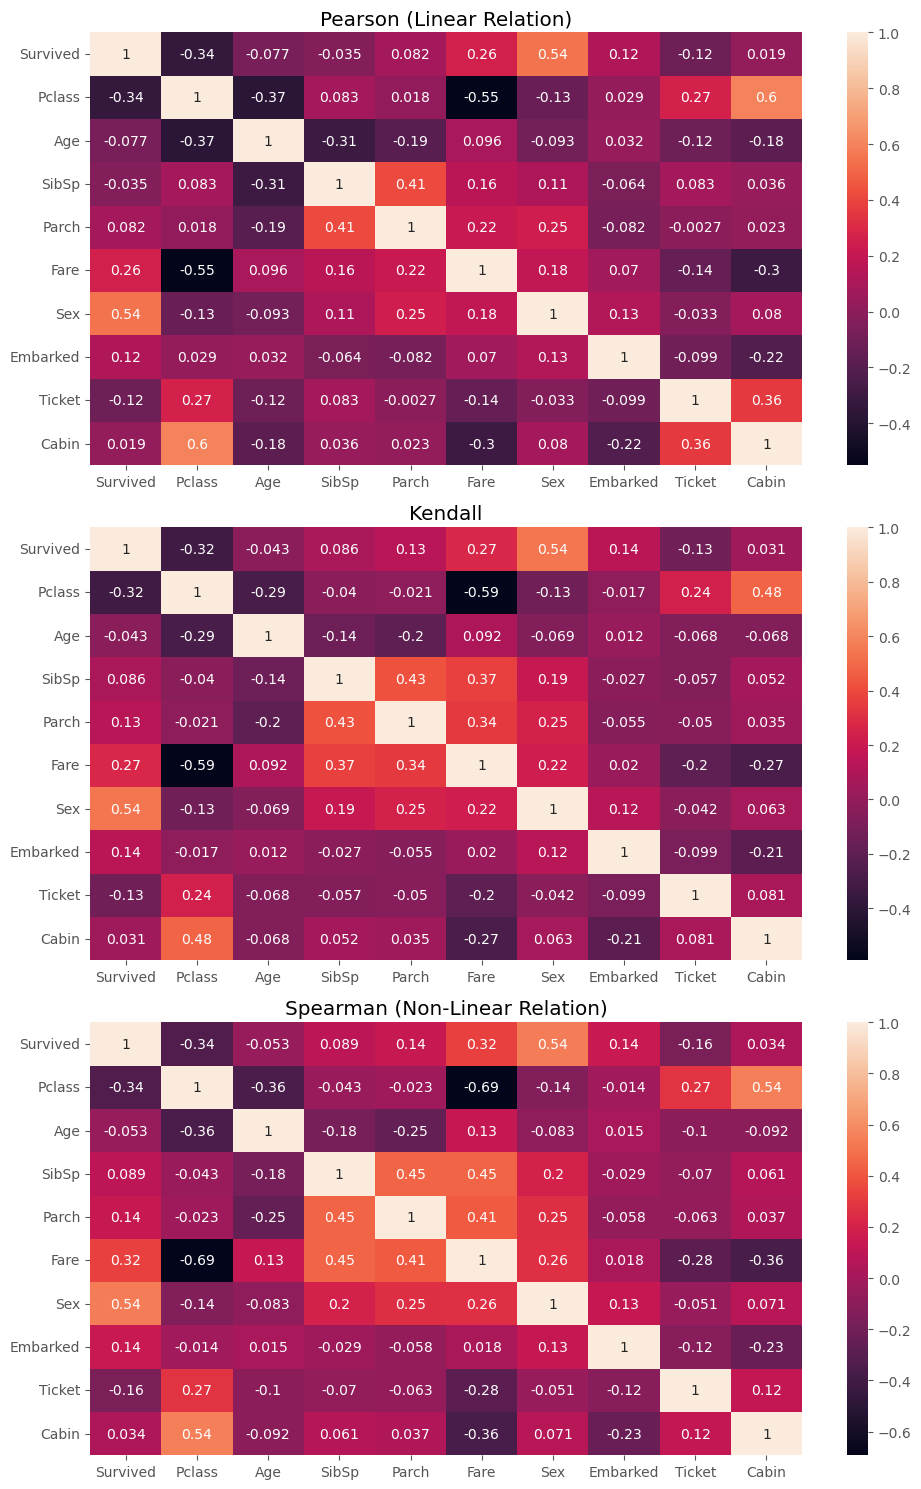

In [52]:
display_corr(df_engineering,prep_vars)

In [53]:
#Cabin Number increase when Pclass increase
df_engineering.groupby('Cabin')['Pclass'].agg(['mean', 'sum', 'min', 'max', 'std','count'])

mean  sum  min  max       std  count
Cabin                                          
1.0    1.000000   15    1    1  0.000000     15
2.0    1.000000   47    1    1  0.000000     47
3.0    1.000000   59    1    1  0.000000     59
4.0    1.121212   37    1    2  0.331434     33
5.0    1.312500   42    1    3  0.644455     32
6.0    2.384615   31    2    3  0.506370     13
7.0    3.000000   12    3    3  0.000000      4
8.0    1.000000    1    1    1       NaN      1

In [54]:
df_engineering.groupby('Cabin')['Fare'].agg(['mean', 'sum', 'min', 'max', 'std','count'])

mean   sum  min  max         std  count
Cabin                                               
1.0     39.266667   589    0   81   17.802354     15
2.0    113.191489  5320    0  512  109.282967     47
3.0     99.728814  5884   26  263   70.249759     59
4.0     56.787879  1874   12  113   29.579086     33
5.0     45.593750  1459    8  134   32.562455     32
6.0     18.384615   239    7   39   11.989846     13
7.0     13.000000    52   10   16    3.464102      4
8.0     35.000000    35   35   35         NaN      1

In [55]:
from sklearn.feature_selection import mutual_info_classif
imp_vars= ['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare',  'Sex', 'Embarked','Ticket','Cabin']
clear_indexes=df_engineering[imp_vars].dropna().index

In [56]:
mutualInfo = pd.Series(mutual_info_classif(df_engineering[imp_vars].dropna(),y=df_engineering['Survived'].iloc[clear_indexes]))
mutualInfo.index = imp_vars
mutualInfo.sort_values(ascending=False)

Survived    0.632798
Sex         0.126595
Age         0.118444
Ticket      0.098151
Fare        0.054055
Cabin       0.027758
Embarked    0.017463
SibSp       0.010942
Pclass      0.000000
Parch       0.000000
dtype: float64

<mark>Results

- Cabin is related to Pclass and Fare. I should look at this before dropping it
    - There are relations but i couldn't extract something valuable from it. Also Cabin has so many missing values too. So I'm dropping it

In [57]:
df_engineering.drop('Cabin',axis=1,inplace=True)

### Name

In [58]:
df_engineering['Surname'] = df_engineering['Name'].str.split(',').str[0]
df_engineering['Title'] = df_engineering['Name'].str.split(',').str[1].str.split('.').str[0].str.lstrip()
df_engineering['Family_size'] = df_engineering.groupby(['Surname', 'Ticket'])['Surname'].transform('size')
df_engineering['Has_family'] = df_engineering['Family_size'].apply(lambda x: 1 if x > 1 else 0)

df_engineering['Title'] = df_engineering['Title'].apply(lambda x: 'Rare' if x in ['Dr','Rev','Mlle','Major','Col','the Countess','Capt','Ms','Sir','Sir','Lady','Mme','Don','Jonkheer'] else x)

title_map={'Mr':1,'Miss':2,'Mrs':3,'Master':4,'Rare':5}
df_engineering['Title'] = df_engineering['Title'].map(title_map)

In [59]:
df_engineering

Pclass                                               Name  Sex   Age  \
0         3                            Braund, Mr. Owen Harris    1  22.0   
1         1  Cumings, Mrs. John Bradley (Florence Briggs Th...    2  38.0   
2         3                             Heikkinen, Miss. Laina    2  26.0   
3         1       Futrelle, Mrs. Jacques Heath (Lily May Peel)    2  35.0   
4         3                           Allen, Mr. William Henry    1  35.0   
..      ...                                                ...  ...   ...   
886       2                              Montvila, Rev. Juozas    1  27.0   
887       1                       Graham, Miss. Margaret Edith    2  19.0   
888       3           Johnston, Miss. Catherine Helen "Carrie"    2   NaN   
889       1                              Behr, Mr. Karl Howell    1  26.0   
890       3                                Dooley, Mr. Patrick    1  32.0   

     SibSp  Parch   Ticket  Fare  Embarked  Survived    Surname  Title  \
0        1      0    21171     7         1         0     Braund      1   
1        1      0    17599    71         2         1    Cumings      3   
2        0      0  3101282     7         1         1  Heikkinen      2   
3        1      0   113803    53         1         1   Futrelle      3   
4        0      0   373450     8         1         0      Allen      1   
..     ...    ...      ...   ...       ...       ...        ...    ...   
886      0      0   211536    13         1         0   Montvila      5   
887      0      0   112053    30         1         1     Graham      2   
888      1      2     6607    23         1         0   Johnston      2   
889      0      0   111369    30         2         1       Behr      1   
890      0      0   370376     7         3         0     Dooley      1   

     Family_size  Has_family  
0              1           0  
1              1           0  
2              1           0  
3              2           1  
4              1           0  
..           ...         ...  
886            1           0  
887            1           0  
888            2           1  
889            1           0  
890            1           0  

[891 rows x 14 columns]

In [60]:
basicEDA(df_engineering[['Surname','Title','Family_size','Has_family']])




====BASIC EDA==== 



 /////////////// Title ///////////////


Type  Na_number  Na_percentage  Nunique  Duplicated_in_column  \
Title  discrete          0            0.0        5                   891   

       Number_of_duplicated_rows  mode  median  
Title                         78     1     1.0

Title    1    2    3   4   5
count  517  182  125  40  27



Unique values:
 [1 3 2 4 5]


 /////////////// Family_size ///////////////


Type  Na_number  Na_percentage  Nunique  \
Family_size  discrete          0            0.0        7   

             Duplicated_in_column  Number_of_duplicated_rows  mode  median  
Family_size                   891                         78     1     1.0

Family_size    1    2   3   4   6   7  5
count        640  144  42  28  18  14  5



Unique values:
 [1 2 4 3 7 5 6]


 /////////////// Has_family ///////////////


Type  Na_number  Na_percentage  Nunique  Duplicated_in_column  \
Has_family  discrete          0            0.0        2                   891   

            Number_of_duplicated_rows  mode  median  
Has_family                         78     0     0.0

Has_family    0    1
count       640  251



Unique values:
 [0 1]


 /////////////// Surname ///////////////


Type  Na_number  Na_percentage  Nunique  \
Surname  categorical           0            0.0      667   

         Duplicated_in_column  Number_of_duplicated_rows       mode  
Surname                   357                         78  Andersson

Unique values cutted early(0:200):
 ['Braund' 'Cumings' 'Heikkinen' 'Futrelle' 'Allen' 'Moran' 'McCarthy'
 'Palsson' 'Johnson' 'Nasser' 'Sandstrom' 'Bonnell' 'Saundercock'
 'Andersson' 'Vestrom' 'Hewlett' 'Rice' 'Williams' 'Vander Planke'
 'Masselmani' 'Fynney' 'Beesley' 'McGowan' 'Sloper' 'Asplund' 'Emir'
 'Fortune' "O'Dwyer" 'Todoroff' 'Uruchurtu' 'Spencer' 'Glynn' 'Wheadon'
 'Meyer' 'Holverson' 'Mamee' 'Cann' 'Nicola-Yarred' 'Ahlin' 'Turpin'
 'Kraeff' 'Laroche' 'Devaney' 'Rogers' 'Lennon' "O'Driscoll" 'Samaan'
 'Arnold-Franchi' 'Panula' 'Nosworthy' 'Harper' 'Faunthorpe' 'Ostby'
 'Woolner' 'Rugg' 'Novel' 'West' 'Goodwin' 'Sirayanian' 'Icard' 'Harris'
 'Skoog' 'Stewart' 'Moubarek' 'Nye' 'Crease' 'Kink' 'Jenkin' 'Hood'
 'Chronopoulos' 'Bing' 'Moen' 'Staneff' 'Moutal' 'Caldwell' 'Dowdell'
 'Waelens' 'Sheerlinck' 'McDermott' 'Carrau' 'Ilett' 'Backstrom' 'Ford'
 'Slocovski' 'Celotti' 'Christmann' 'Andreasson' 'Chaffee' 'Dean' 'Coxon'
 'Shorney' 'Goldschmidt' 'Greenfield' 'Doling' 'Kantor'

In [61]:
df_engineering.drop(columns=['Name','Surname'],inplace=True)

In [62]:
basicEDA(df_engineering[['Title','Family_size','Has_family']])




====BASIC EDA==== 



 /////////////// Title ///////////////


Type  Na_number  Na_percentage  Nunique  Duplicated_in_column  \
Title  discrete          0            0.0        5                   891   

       Number_of_duplicated_rows  mode  median  
Title                        863     1     1.0

Title    1    2    3   4   5
count  517  182  125  40  27



Unique values:
 [1 3 2 4 5]


 /////////////// Family_size ///////////////


Type  Na_number  Na_percentage  Nunique  \
Family_size  discrete          0            0.0        7   

             Duplicated_in_column  Number_of_duplicated_rows  mode  median  
Family_size                   891                        863     1     1.0

Family_size    1    2   3   4   6   7  5
count        640  144  42  28  18  14  5



Unique values:
 [1 2 4 3 7 5 6]


 /////////////// Has_family ///////////////


Type  Na_number  Na_percentage  Nunique  Duplicated_in_column  \
Has_family  discrete          0            0.0        2                   891   

            Number_of_duplicated_rows  mode  median  
Has_family                        863     0     0.0

Has_family    0    1
count       640  251



Unique values:
 [0 1]


Variables and their types on table

Number of numerical variables => 3 
Numerical Variables=> ['Title', 'Family_size', 'Has_family']
Number of continuous variables => 0 
Continuous Variables=> []
Number of discrete variables => 3 
Discrete Variables=> ['Title', 'Family_size', 'Has_family']
Number of categorical variables => 0 
Categorical Variables=> []


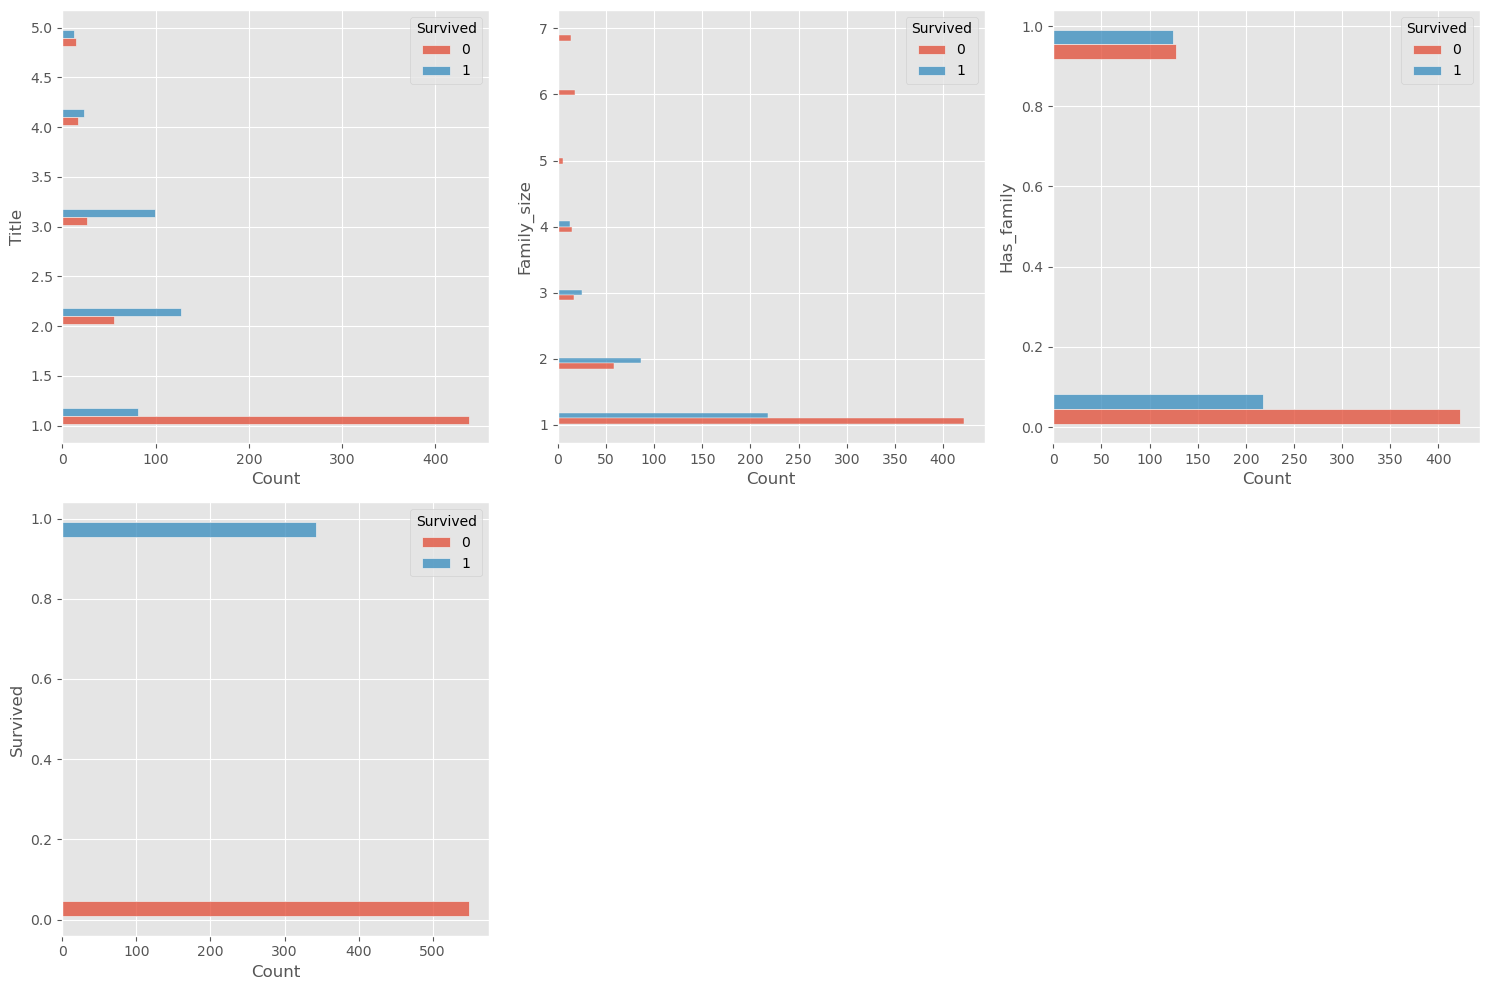

In [63]:
feature_distr(df_engineering[['Title','Family_size','Has_family','Survived']],'Survived')

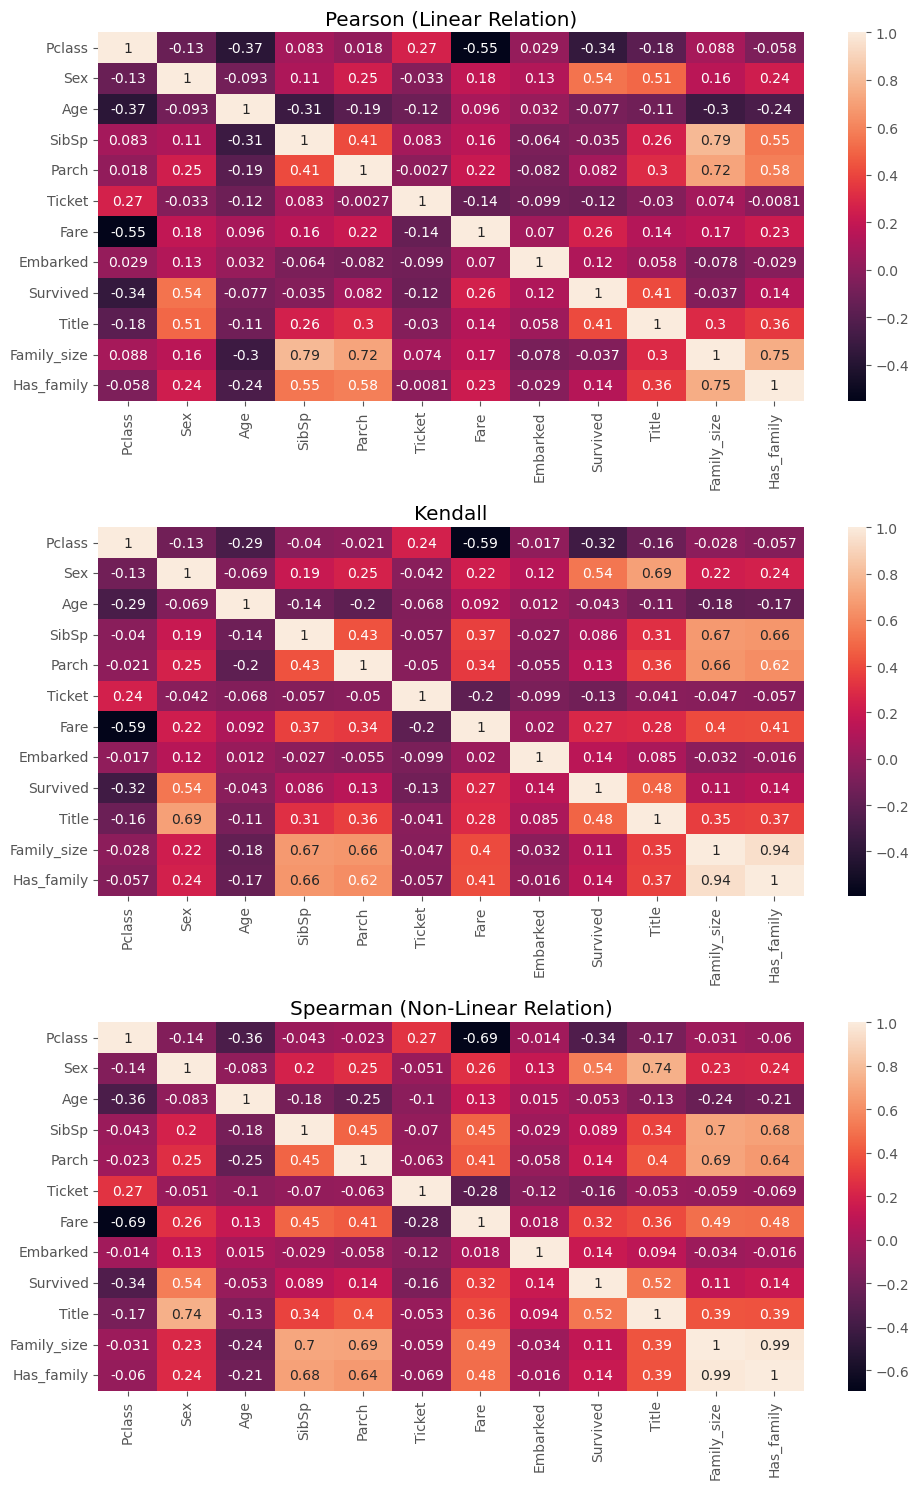

In [64]:
display_corr(df_engineering,df_engineering.columns)

In [65]:
from sklearn.feature_selection import mutual_info_classif
imp_vars= ['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare',  'Sex', 'Embarked','Ticket','Title','Family_size','Has_family']
clear_indexes=df_engineering[imp_vars].dropna().index

In [66]:
mutualInfo = pd.Series(mutual_info_classif(df_engineering[imp_vars].dropna(),y=df_engineering['Survived'].iloc[clear_indexes]))
mutualInfo.index = imp_vars
mutualInfo.sort_values(ascending=False)

Survived       0.676132
Sex            0.156838
Title          0.137527
Ticket         0.111046
Fare           0.094823
Pclass         0.070644
Parch          0.021180
SibSp          0.020085
Has_family     0.017603
Embarked       0.011795
Age            0.011394
Family_size    0.008269
dtype: float64

In [67]:
df_engineering.drop(columns=['Has_family'],inplace=True)

<mark>Notes

- Title has many categories with value counts are lower than 10. I concatenated them

- I dropped Name and Surname. Because they had many unique values.

- Title related with Survived

- I should drop Family_size or Has_family.I decided to drop Has_family after MI step

### Age

In [68]:
df_engineering['Age_binned'] = np.nan
df_engineering.loc[(df_engineering['Age']<=12),'Age_binned'] = 'Age_0-12'
df_engineering.loc[(df_engineering['Age']>12) & (df_engineering['Age']<=19),'Age_binned'] = 'Age 12-19'
#df_engineering.loc[(df_engineering['Age']>19) & (df_engineering['Age']<=25),'Age_binned'] = 'Age 20-25'
df_engineering.loc[(df_engineering['Age']>19) & (df_engineering['Age']<=35),'Age_binned'] = 'Age 20-35'
df_engineering.loc[(df_engineering['Age']>35) & (df_engineering['Age']<=50),'Age_binned'] = 'Age 35-50'
df_engineering.loc[(df_engineering['Age']>50),'Age_binned'] = 'Age 50+'

age_map= {'Age_0-12':1,'Age 12-19':2,'Age 20-35':3,'Age 35-50':4,'Age 50+':5}
df_engineering['Age_binned'] = df_engineering['Age_binned'].map(age_map)

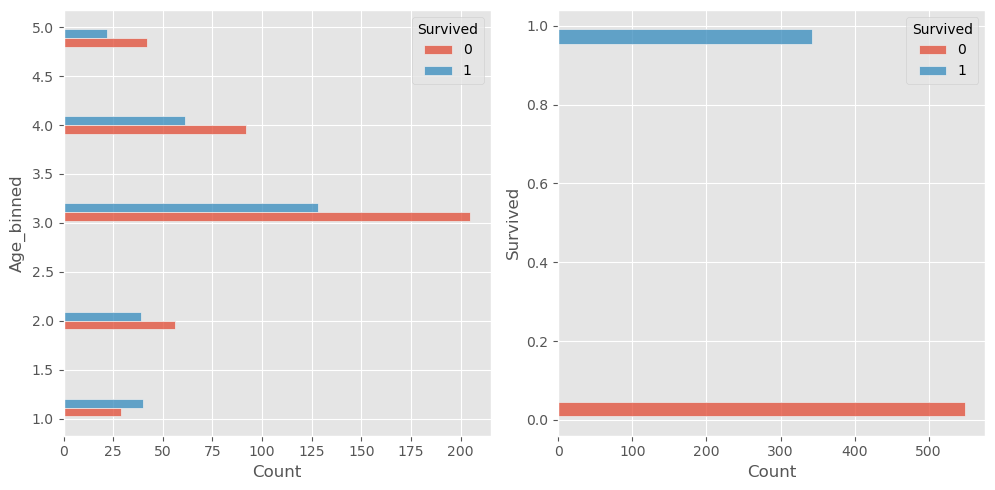

In [69]:
feature_distr(df_engineering[['Age_binned','Survived']],'Survived')

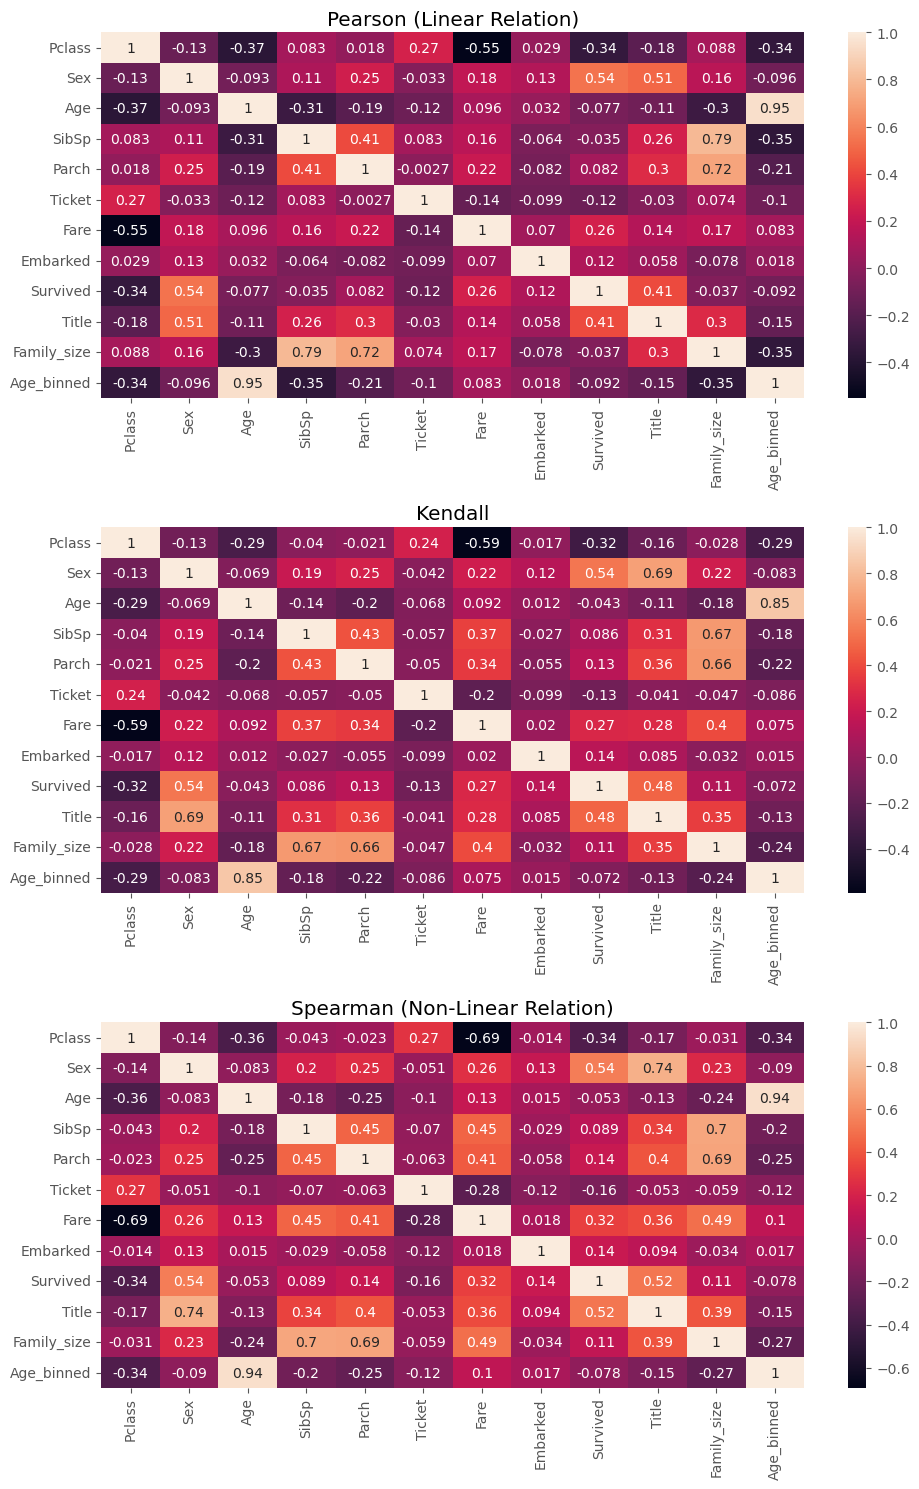

In [70]:
display_corr(df_engineering,df_engineering.columns)

In [71]:
from sklearn.feature_selection import mutual_info_classif
imp_vars= ['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare',  'Sex', 'Embarked','Ticket','Title','Family_size','Age_binned']
clear_indexes=df_engineering[imp_vars].dropna().index

In [72]:
mutualInfo = pd.Series(mutual_info_classif(df_engineering[imp_vars].dropna(),y=df_engineering['Survived'].iloc[clear_indexes]))
mutualInfo.index = imp_vars
mutualInfo.sort_values(ascending=False)

Survived       0.676132
Title          0.159355
Sex            0.149276
Ticket         0.117463
Fare           0.088535
Pclass         0.058273
SibSp          0.048244
Parch          0.033384
Family_size    0.032457
Age            0.030580
Embarked       0.014958
Age_binned     0.002543
dtype: float64

<mark> Notes

- Binning is not useful.

In [73]:
df_engineering.drop(columns=['Age_binned'],inplace=True)

### Save Feature Engineering

In [511]:
#df_engineering = oe.inverse_transform(df_engineering)

In [16]:
df_engineering.to_csv('processed_train.csv', index=False)

NameError: name 'df_engineering' is not defined

# Multivariate Outlier Detections

In [182]:
#Train set after Feature Engineering => Title is ordinal encoded
df_engineering2 = pd.read_csv('processed_train.csv')
df_engineering2

Pclass  Sex   Age  SibSp  Parch   Ticket  Fare  Embarked  Survived  \
0         3    1  22.0      1      0    21171     7         1         0   
1         1    2  38.0      1      0    17599    71         2         1   
2         3    2  26.0      0      0  3101282     7         1         1   
3         1    2  35.0      1      0   113803    53         1         1   
4         3    1  35.0      0      0   373450     8         1         0   
..      ...  ...   ...    ...    ...      ...   ...       ...       ...   
886       2    1  27.0      0      0   211536    13         1         0   
887       1    2  19.0      0      0   112053    30         1         1   
888       3    2   NaN      1      2     6607    23         1         0   
889       1    1  26.0      0      0   111369    30         2         1   
890       3    1  32.0      0      0   370376     7         3         0   

     Title  Family_size  
0        1            1  
1        3            1  
2        2            1  
3        3            2  
4        1            1  
..     ...          ...  
886      5            1  
887      2            1  
888      2            2  
889      1            1  
890      1            1  

[891 rows x 11 columns]

In [183]:
df_engineering2['Age'] = df_engineering2['Age'].fillna(df_engineering2[df_engineering2['Survived']==0]['Age'].mean())

In [184]:
X_tr,y_tr = df_engineering2.drop(columns='Survived'),df_engineering2['Survived']

## Isolation Forest

In [186]:
iForest = IsolationForest(contamination=0.1)
iForest.fit(X_tr)

IsolationForest(contamination=0.1)

In [187]:
outliers_iForest = pd.DataFrame(iForest.predict(X_tr),columns=['is_outlier'])
iForest_indexes = outliers_iForest[outliers_iForest['is_outlier']==-1].index
outliers[outliers['is_outlier']==-1].T

7    13   16   25   27   43   50   59   63   68   ...  813  819  \
is_outlier   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1  ...   -1   -1   

            824  827  829  846  850  858  863  885  
is_outlier   -1   -1   -1   -1   -1   -1   -1   -1  

[1 rows x 89 columns]

## Elliptic Envelope

In [188]:
eEnv = EllipticEnvelope(contamination=0.1)
outliers_Env = pd.DataFrame(eEnv.fit_predict(X_tr),columns=['is_outlier'])
env_indexes = outliers_Env[outliers_Env['is_outlier']==-1].index
outliers_Env[outliers_Env['is_outlier']==-1].T

13   25   27   50   59   63   68   71   78   85   ...  819  824  \
is_outlier   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1  ...   -1   -1   

            827  846  848  850  856  858  863  885  
is_outlier   -1   -1   -1   -1   -1   -1   -1   -1  

[1 rows x 89 columns]

## Local Outlier Factor

In [189]:
lof = LocalOutlierFactor()
outliers_lof = pd.DataFrame(lof.fit_predict(X_tr),columns=['is_outlier'])
lof_indexes = outliers_lof[outliers_lof['is_outlier']==-1].index
outliers_lof[outliers_lof['is_outlier']==-1].T

8    10   18   32   33   38   45   51   53   54   ...  829  833  \
is_outlier   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1  ...   -1   -1   

            838  851  857  868  869  873  874  886  
is_outlier   -1   -1   -1   -1   -1   -1   -1   -1  

[1 rows x 151 columns]

## One Class SVM

In [190]:
ocSVM = OneClassSVM(nu=0.1)
outliers_ocSVM = pd.DataFrame(ocSVM.fit_predict(X_tr),columns=['is_outlier'])
ocSVM_indexes = outliers_ocSVM[outliers_ocSVM['is_outlier']==-1].index
outliers_ocSVM[outliers_ocSVM['is_outlier']==-1].T

2    16   50   68   74   77   85   87   95   104  ...  824  826  \
is_outlier   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1  ...   -1   -1   

            837  838  840  841  855  872  884  885  
is_outlier   -1   -1   -1   -1   -1   -1   -1   -1  

[1 rows x 94 columns]

## Merging Results

In [191]:
all_indexes = pd.concat([pd.DataFrame(iForest_indexes),pd.DataFrame(env_indexes),pd.DataFrame(lof_indexes),pd.DataFrame(ocSVM_indexes)],axis=0)
all_indexes.T

0   1   2   3   4   5   6   7   8   9   ...   84   85   86   87   88   89  \
0   7  13  16  25  27  43  50  59  63  68  ...  824  826  837  838  840  841   

    90   91   92   93  
0  855  872  884  885  

[1 rows x 423 columns]

In [192]:
print('Number of absolute outliers:',len(all_indexes.value_counts()[all_indexes.value_counts()>=3]))
outliers_indexes = all_indexes.value_counts()[all_indexes.value_counts()>=3].reset_index()[0]

Number of absolute outliers: 26


## Deleting Outliers

In [193]:
X_tr.drop(outliers_indexes,inplace=True)
y_tr.drop(outliers_indexes,inplace=True)

# Baseline Models and Hyperparameter Optimization with Optuna

#### Pipeline and data splitting

In [22]:
num_vars = ['Pclass', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Family_size']
cat_vars = ['Sex', 'Embarked', 'Title']

In [23]:
X_train, y_train, X_test, y_test = df_train.drop(columns='Survived').copy(),df_train['Survived'].copy(), df_test.copy() ,gender_sbm['Survived'].copy()

### Optuna Baseline Models

In [24]:
def instantiate_cat_encoder(trial):
    #Choosing the Categorical encoder
    cat_encoder_name = trial.suggest_categorical('cat_encoder_name',['OneHotEncoder','OrdinalEncoder','BinaryEncoder','CountEncoder','WOEEncoder'])
    if cat_encoder_name == 'OneHotEncoder':
        encoder_obj = OneHotEncoder()
    elif cat_encoder_name == 'OrdinalEncoder':
        encoder_obj = OrdinalEncoder()
    elif cat_encoder_name == 'BinaryEncoder':
        encoder_obj = BinaryEncoder()
    elif cat_encoder_name == 'CountEncoder':
        encoder_obj = CountEncoder()
    else:
        encoder_obj = WOEEncoder()

    return encoder_obj

In [47]:
def instantiate_scaler(trial):
    scaler_name = trial.suggest_categorical('scaler_name',['StandardScaler','MinMaxScaler','QuantileTransformer','RobustScaler','PowerTransformer'])
    before_transformer = 'passthrough'
    if scaler_name == 'StandardScaler':
        scaler_obj = StandardScaler(with_mean=False)
    elif scaler_name == 'MinMaxScaler':
        scaler_obj = MinMaxScaler()
    elif scaler_name == 'QuantileTransformer':
        scaler_obj = QuantileTransformer(output_distribution='normal')
    elif scaler_name == 'RobustScaler':
        scaler_obj = RobustScaler(quantile_range=(0.05,0.95))
    else:
        bTransformer_name = trial.suggest_categorical('bTransformer_name',['passthrough','bMinMax'])
        if bTransformer_name == 'bMinMax':
            before_transformer = MinMaxScaler()
        scaler_obj = PowerTransformer()

    return scaler_obj,before_transformer

In [26]:
def instantiate_dim_red(trial):
    ## Choosing the dimensionality reduction algorithm //'SpectralEmbedding','TSNE'
    dim_red_name = trial.suggest_categorical('dim_red_name',['PCA','KernelPCA','LinearDiscriminantAnalysis','Isomap','LocallyLinearEmbedding'])
    
    if dim_red_name == 'PCA':
        dim_red_obj = PCA(n_components=0.95)
    elif dim_red_name == 'KernelPCA':
        dim_red_obj = KernelPCA(n_components=4 , kernel = 'sigmoid')
    elif dim_red_name == 'LinearDiscriminantAnalysis':
        dim_red_obj = LinearDiscriminantAnalysis()
    elif dim_red_name == 'Isomap':
        dim_red_obj = Isomap(n_components=4)
    elif dim_red_name == 'LocallyLinearEmbedding':
        dim_red_obj = LocallyLinearEmbedding(n_neighbors=10,n_components=4)
    elif dim_red_name == 'SpectralEmbedding':
        dim_red_obj = SpectralEmbedding(n_components=4)
    else:
        dim_red_obj = TSNE(n_components=4)

    return dim_red_obj

In [49]:
def instantiate_model(trial):
    model_name = trial.suggest_categorical('classifier_name',['RidgeClassifier','LogisticRegression','KNeighborsClassifier',\
                                                          'AdaBoostClassifier','GradientBoostingClassifier','SVC',\
                                                          'RandomForestClassifier','NaiveBayes'])
    if model_name == 'RidgeClassifier':
        model_obj = RidgeClassifier()
    elif model_name == 'LogisticRegression':
        model_obj = LogisticRegression()
    elif model_name == 'KNeighborsClassifier':
        model_obj = KNeighborsClassifier()
    elif model_name == 'AdaBoostClassifier':
        model_obj = AdaBoostClassifier(learning_rate=0.5, random_state=42)
    elif model_name == 'GradientBoostingClassifier':
        model_obj = GradientBoostingClassifier()
    elif model_name == 'SVC':
        model_obj = SVC()
    elif model_name == 'NaiveBayes':
        model_obj = GaussianNB()
    else:
        model_obj = RandomForestClassifier()

    return model_obj

In [54]:
def objective_base_functionized(trial):
    
    #KNNImputer n neighbors
    knn_imp_n_neighbors = trial.suggest_int('knn_imp_n_neighbors',2,6)
    #Choosing the Categorical encoder
    encoder_obj = instantiate_cat_encoder(trial)
    #Choosing the scaler
    scaler_obj,before_transformer = instantiate_scaler(trial)
    ## Choosing the dimensionality reduction algorithm //'SpectralEmbedding','TSNE'
    dim_red_obj = instantiate_dim_red(trial)
    ## Choosing the predictor algorithm
    model_obj = instantiate_model(trial)
    
    #Selecting features after feature engineering steps
    numerical_columns = FeatureEngineering().fit_transform(X_train,y_train).select_dtypes(exclude=['category','object']).columns
    categorical_columns = FeatureEngineering().fit_transform(X_train,y_train).select_dtypes(include=['category','object']).columns
    
    ##Creating pipeline
    numerical_pipeline = Pipeline([
        ('imputer_num',KNNImputer(n_neighbors=knn_imp_n_neighbors))        
    ])
    categorical_pipeline = Pipeline([
        ('imputer_cat',SimpleImputer(strategy='most_frequent')),
        ('encoder',encoder_obj)
    ])
    preprocessor = ColumnTransformer([
        ('numerical_pipeline',numerical_pipeline,numerical_columns),
        ('categorical_pipeline',categorical_pipeline,categorical_columns)
    ])

    model_pipeline = Pipeline([
        ('feature_engineering',FeatureEngineering()),
        ('preprocessor',preprocessor),
        ('before_scaler',before_transformer),
        ('scaler',scaler_obj),
        ('dimensionality_reduction',dim_red_obj),
        ('model',model_obj)
    ])

    kf = KFold(n_splits=5, shuffle=True, random_state=42)    
    scores = cross_val_score(model_pipeline, X_train, y_train, scoring='accuracy', cv=kf)
    #print('min:{}\nmax:{}\nall scores:{}'.format(np.min(scores),np.max(scores),scores))    
    return np.min([np.mean(scores), np.median(scores)])

In [55]:
study_functionized = optuna.create_study(direction='maximize')

[I 2024-06-24 10:58:57,222] A new study created in memory with name: no-name-318e7408-f3fc-4337-8793-522a281cdb4f


In [56]:
study_functionized.optimize(func=objective_base_functionized,n_trials=400,n_jobs=-1)

[I 2024-06-24 10:58:59,986] Trial 0 finished with value: 0.8044692737430168 and parameters: {'knn_imp_n_neighbors': 2, 'cat_encoder_name': 'OneHotEncoder', 'scaler_name': 'StandardScaler', 'dim_red_name': 'PCA', 'classifier_name': 'LogisticRegression'}. Best is trial 0 with value: 0.8044692737430168.
[I 2024-06-24 10:59:00,085] Trial 5 finished with value: 0.8044692737430168 and parameters: {'knn_imp_n_neighbors': 5, 'cat_encoder_name': 'BinaryEncoder', 'scaler_name': 'MinMaxScaler', 'dim_red_name': 'PCA', 'classifier_name': 'SVC'}. Best is trial 0 with value: 0.8044692737430168.
[I 2024-06-24 10:59:00,178] Trial 3 finished with value: 0.616194840248572 and parameters: {'knn_imp_n_neighbors': 6, 'cat_encoder_name': 'CountEncoder', 'scaler_name': 'RobustScaler', 'dim_red_name': 'PCA', 'classifier_name': 'SVC'}. Best is trial 0 with value: 0.8044692737430168.
[I 2024-06-24 10:59:00,383] Trial 6 finished with value: 0.7932960893854749 and parameters: {'knn_imp_n_neighbors': 5, 'cat_encode

In [58]:
study_functionized.trials_dataframe(attrs=('number','value','params','duration')).sort_values(by='value',ascending=False)[:50]

number     value params_bTransformer_name params_cat_encoder_name  \
293     293  0.815642                      NaN           BinaryEncoder   
303     303  0.815642                      NaN           BinaryEncoder   
296     296  0.815642                      NaN           BinaryEncoder   
297     297  0.815642                      NaN           BinaryEncoder   
298     298  0.815642                      NaN           BinaryEncoder   
299     299  0.815642                      NaN           BinaryEncoder   
300     300  0.815642                      NaN           BinaryEncoder   
301     301  0.815642                      NaN           BinaryEncoder   
382     382  0.815642                      NaN           BinaryEncoder   
302     302  0.815642                      NaN           BinaryEncoder   
304     304  0.815642                      NaN           BinaryEncoder   
310     310  0.815642                      NaN           BinaryEncoder   
305     305  0.815642                      NaN           BinaryEncoder   
306     306  0.815642                      NaN           BinaryEncoder   
383     383  0.815642                      NaN           BinaryEncoder   
385     385  0.815642                      NaN           BinaryEncoder   
386     386  0.815642                      NaN           BinaryEncoder   
307     307  0.815642                      NaN           BinaryEncoder   
308     308  0.815642                      NaN           BinaryEncoder   
309     309  0.815642                      NaN           BinaryEncoder   
295     295  0.815642                      NaN           BinaryEncoder   
294     294  0.815642                      NaN           BinaryEncoder   
292     292  0.815642                      NaN           BinaryEncoder   
291     291  0.815642                      NaN           BinaryEncoder   
380     380  0.815642                      NaN           BinaryEncoder   
377     377  0.815642                      NaN           BinaryEncoder   
376     376  0.815642                      NaN           BinaryEncoder   
381     381  0.815642                      NaN           BinaryEncoder   
375     375  0.815642                      NaN           BinaryEncoder   
374     374  0.815642                      NaN           BinaryEncoder   
373     373  0.815642                      NaN           BinaryEncoder   
88       88  0.815642                      NaN           BinaryEncoder   
378     378  0.815642                      NaN           BinaryEncoder   
379     379  0.815642                      NaN           BinaryEncoder   
85       85  0.815642                      NaN           BinaryEncoder   
370     370  0.815642                      NaN           BinaryEncoder   
283     283  0.815642                      NaN           BinaryEncoder   
287     287  0.815642                      NaN           BinaryEncoder   
288     288  0.815642                      NaN           BinaryEncoder   
289     289  0.815642                      NaN           BinaryEncoder   
290     290  0.815642                      NaN           BinaryEncoder   
390     390  0.815642                      NaN           BinaryEncoder   
384     384  0.815642                      NaN           BinaryEncoder   
366     366  0.815642                      NaN           BinaryEncoder   
367     367  0.815642                      NaN           BinaryEncoder   
333     333  0.815642                      NaN           BinaryEncoder   
334     334  0.815642                      NaN           BinaryEncoder   
335     335  0.815642                      NaN           BinaryEncoder   
397     397  0.815642                      NaN           BinaryEncoder   
336     336  0.815642                      NaN           BinaryEncoder   

    params_classifier_name params_dim_red_name  params_knn_imp_n_neighbors  \
293                    SVC                 PCA                           2   
303        RidgeClassifier                 PCA                           2

In [59]:
study_functionized.trials_dataframe(attrs=('number','value','params','duration')).sort_values(by='value',ascending=False)[50:100]

number     value params_bTransformer_name params_cat_encoder_name  \
337     337  0.815642                      NaN           BinaryEncoder   
338     338  0.815642                      NaN           BinaryEncoder   
339     339  0.815642                      NaN           BinaryEncoder   
355     355  0.815642                      NaN           BinaryEncoder   
331     331  0.815642                      NaN           BinaryEncoder   
364     364  0.815642                      NaN           BinaryEncoder   
354     354  0.815642                      NaN           BinaryEncoder   
353     353  0.815642                      NaN           BinaryEncoder   
348     348  0.815642                      NaN           BinaryEncoder   
12       12  0.815642              passthrough           OneHotEncoder   
349     349  0.815642                      NaN           BinaryEncoder   
350     350  0.815642                      NaN           BinaryEncoder   
351     351  0.815642                      NaN           BinaryEncoder   
352     352  0.815642                      NaN           BinaryEncoder   
332     332  0.815642                      NaN           BinaryEncoder   
330     330  0.815642                      NaN           BinaryEncoder   
315     315  0.815642                      NaN           BinaryEncoder   
398     398  0.815642                      NaN           BinaryEncoder   
311     311  0.815642                      NaN           BinaryEncoder   
329     329  0.815642                      NaN           BinaryEncoder   
313     313  0.815642                      NaN           BinaryEncoder   
314     314  0.815642                      NaN           BinaryEncoder   
312     312  0.815642                      NaN           BinaryEncoder   
316     316  0.815642                      NaN           BinaryEncoder   
328     328  0.815642                      NaN           BinaryEncoder   
317     317  0.815642                      NaN           BinaryEncoder   
318     318  0.815642                      NaN           BinaryEncoder   
323     323  0.815642                      NaN           BinaryEncoder   
266     266  0.814607                      NaN           OneHotEncoder   
269     269  0.814607                      NaN           OneHotEncoder   
144     144  0.813684                      NaN           OneHotEncoder   
256     256  0.813684                      NaN           OneHotEncoder   
257     257  0.813684                      NaN           OneHotEncoder   
173     173  0.813684                      NaN           OneHotEncoder   
169     169  0.813684                      NaN           OneHotEncoder   
254     254  0.813684                      NaN           OneHotEncoder   
253     253  0.813684                      NaN           OneHotEncoder   
252     252  0.813684                      NaN           OneHotEncoder   
251     251  0.813684                      NaN           OneHotEncoder   
255     255  0.813684                      NaN           OneHotEncoder   
150     150  0.813684                      NaN           OneHotEncoder   
258     258  0.813684                      NaN           OneHotEncoder   
160     160  0.813684                      NaN           OneHotEncoder   
149     149  0.813684                      NaN           OneHotEncoder   
148     148  0.813684                      NaN           OneHotEncoder   
152     152  0.813684                      NaN           OneHotEncoder   
147     147  0.813684                      NaN           OneHotEncoder   
153     153  0.813684                      NaN           OneHotEncoder   
146     146  0.813684                      NaN           OneHotEncoder   
145     145  0.813684                      NaN           OneHotEncoder   

    params_classifier_name         params_dim_red_name  \
337        RidgeClassifier                         PCA   
338        RidgeClassifier                         PCA   
339        RidgeClassifier                         PCA  

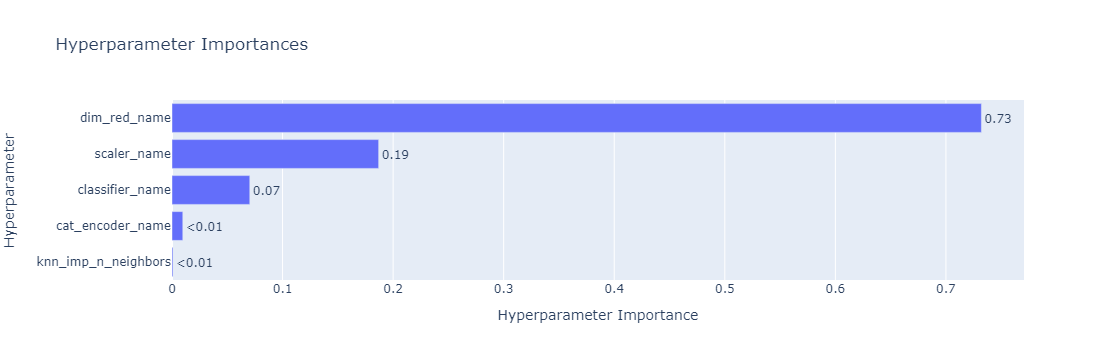

In [60]:
optuna.visualization.plot_param_importances(study=study_functionized)

In [86]:
#Number of selection of predictors and transformers in top 100 and top 70 trials
top_100_trials = study_functionized.trials_dataframe(attrs=('number','value','params','duration')).sort_values(by='value',ascending=False)[:100]
top_70_trials = study_functionized.trials_dataframe(attrs=('number','value','params','duration')).sort_values(by='value',ascending=False)[:70]
display(top_100_trials['params_cat_encoder_name'].value_counts(),'---top 70',top_70_trials['params_cat_encoder_name'].value_counts(),'-'*50)
display(top_100_trials['params_classifier_name'].value_counts(),'---top 70',top_70_trials['params_classifier_name'].value_counts(),'-'*50)
display(top_100_trials['params_dim_red_name'].value_counts(),'---top 70',top_70_trials['params_dim_red_name'].value_counts(),'-'*50)
display(top_100_trials['params_knn_imp_n_neighbors'].value_counts(),'---top 70',top_70_trials['params_knn_imp_n_neighbors'].value_counts(),'-'*50)
display(top_100_trials['params_bTransformer_name'].value_counts(),'---top 70',top_70_trials['params_bTransformer_name'].value_counts(),'-'*50)
display(top_100_trials['params_scaler_name'].value_counts(),'---top 70',top_70_trials['params_scaler_name'].value_counts(),'-'*50)

params_cat_encoder_name
BinaryEncoder    77
OneHotEncoder    23
Name: count, dtype: int64

'---top 70'

params_cat_encoder_name
BinaryEncoder    69
OneHotEncoder     1
Name: count, dtype: int64

'--------------------------------------------------'

params_classifier_name
RidgeClassifier    64
SVC                36
Name: count, dtype: int64

'---top 70'

params_classifier_name
RidgeClassifier    56
SVC                14
Name: count, dtype: int64

'--------------------------------------------------'

params_dim_red_name
PCA                           78
LinearDiscriminantAnalysis    22
Name: count, dtype: int64

'---top 70'

params_dim_red_name
PCA    70
Name: count, dtype: int64

'--------------------------------------------------'

params_knn_imp_n_neighbors
2    70
4    21
6     5
5     4
Name: count, dtype: int64

'---top 70'

params_knn_imp_n_neighbors
2    60
6     5
5     4
4     1
Name: count, dtype: int64

'--------------------------------------------------'

params_bTransformer_name
passthrough    1
Name: count, dtype: int64

'---top 70'

params_bTransformer_name
passthrough    1
Name: count, dtype: int64

'--------------------------------------------------'

params_scaler_name
StandardScaler      98
PowerTransformer     1
RobustScaler         1
Name: count, dtype: int64

'---top 70'

params_scaler_name
StandardScaler      69
PowerTransformer     1
Name: count, dtype: int64

'--------------------------------------------------'

In [103]:
#Number of selection of predictors and transformers in top 50 and top 20 non-duplicated trials
non_duplicated_trials = study_functionized.trials_dataframe(attrs=('value','params')).sort_values(by='value',ascending=False).drop_duplicates()
display(non_duplicated_trials['params_cat_encoder_name'][:50].value_counts(),'---top 20',non_duplicated_trials['params_cat_encoder_name'][:20].value_counts(),'-'*50)
display(non_duplicated_trials['params_classifier_name'][:100].value_counts(),'---top 75',non_duplicated_trials['params_classifier_name'][:75].value_counts(),'-'*50)
display(non_duplicated_trials['params_dim_red_name'][:50].value_counts(),'---top 20',non_duplicated_trials['params_dim_red_name'][:20].value_counts(),'-'*50)
display(non_duplicated_trials['params_knn_imp_n_neighbors'][:50].value_counts(),'---top 20',non_duplicated_trials['params_knn_imp_n_neighbors'][:20].value_counts(),'-'*50)
display(non_duplicated_trials['params_bTransformer_name'][:50].value_counts(),'---top 20',non_duplicated_trials['params_bTransformer_name'][:20].value_counts(),'-'*50)
display(non_duplicated_trials['params_scaler_name'][:50].value_counts(),'---top 20',non_duplicated_trials['params_scaler_name'][:20].value_counts(),'-'*50)

NameError: name 'study_functionized' is not defined

<mark>Results:

Cat encoder => Binary,One hot 

Classifier => RidgeClf , SVC , GBM

DimRed => PCA , LinearDiscriminantAnalysis

params_knn_imp_n_neighbors => 4

params_bTransformer_name => 'passthrough'

scaler => StandardScaler

### Optuna HyperParameter Optimization

#### Functions for Objective

In [193]:
def instantiate_cat_encoder(trial):
    #Choosing the Categorical encoder
    cat_encoder_name = trial.suggest_categorical('cat_encoder_name',['OneHotEncoder','BinaryEncoder'])
    if cat_encoder_name == 'OneHotEncoder':
        encoder_obj = OneHotEncoder()    
    else:
        encoder_obj = BinaryEncoder()    

    return encoder_obj

In [194]:
def instantiate_dim_red(trial):
    ## Choosing the dimensionality reduction algorithm //'SpectralEmbedding','TSNE'
    dim_red_name = trial.suggest_categorical('dim_red_name',['PCA','LinearDiscriminantAnalysis'])
    
    if dim_red_name == 'PCA':
        pca_n_components = trial.suggest_float('pca_n_components',0.5,1.0)
        dim_red_obj = PCA(n_components=0.95)    
    else:        
        dim_red_obj = LinearDiscriminantAnalysis()   

    return dim_red_obj

In [195]:
def instantiate_model(trial,model_list):
    model_name = trial.suggest_categorical('classifier_name',model_list)
    if model_name == 'RidgeClassifier':
        ridge_alpha = trial.suggest_float('ridge_alpha', 1e-6, 1e3, log=True)
        model_obj = RidgeClassifier(alpha=ridge_alpha)    
    elif model_name == 'GradientBoostingClassifier':
        gbm_n_estimators = trial.suggest_int('gbm_n_estimators', 100, 1000)
        gbm_learning_rate = trial.suggest_float('gbm_learning_rate', 0.01, 0.2)
        gbm_max_depth = trial.suggest_int('gbm_max_depth', 3, 10)
        gbm_min_samples_split = trial.suggest_int('gbm_min_samples_split', 2, 20)
        gbm_min_samples_leaf = trial.suggest_int('gbm_min_samples_leaf', 1, 20)
        gbm_subsample = trial.suggest_float('gbm_subsample', 0.6, 1.0)
        gbm_max_features = trial.suggest_categorical('gbm_max_features', ['auto', 'sqrt', 'log2', None])
        model_obj = GradientBoostingClassifier(learning_rate=gbm_learning_rate,n_estimators=gbm_n_estimators,max_depth=gbm_max_depth,
                                                   min_samples_split=gbm_min_samples_split,min_samples_leaf=gbm_min_samples_leaf,subsample=gbm_subsample,
                                                  max_features=gbm_max_features)
    else:
        svc_C = trial.suggest_float('svc_C', 0.1, 1000, log=True)
        svc_kernel = trial.suggest_categorical('svc_kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
        
        # Sadece belirli çekirdekler için gamma ve degree parametrelerini öner
        if svc_kernel in ['rbf', 'poly', 'sigmoid']:
            svc_gamma = trial.suggest_float('svc_gamma', 1e-6, 1, log=True)
        else:
            svc_gamma = 'scale'
        
        if svc_kernel == 'poly':
            svc_degree = trial.suggest_int('svc_degree', 2, 5)
        else:
            svc_degree = 3 
    
        model_obj = SVC(C=svc_C,kernel=svc_kernel,gamma=svc_gamma,degree=svc_degree)    

    return model_obj

#### Objective Function

In [196]:
def objective_tuning(trial,model_list):    

    knn_imp_n_neighbors = 4
    #Choosing the Categorical encoder
    encoder_obj = instantiate_cat_encoder(trial)
    #Choosing the scaler
    scaler_obj,before_transformer = StandardScaler(with_mean=False),'passthrough'
    ## Choosing the dimensionality reduction algorithm //'SpectralEmbedding','TSNE'
    dim_red_obj = instantiate_dim_red(trial)
    ## Choosing the predictor algorithm
    model_obj = instantiate_model(trial,model_list=model_list)
    
    #Selecting features after feature engineering steps
    numerical_columns = FeatureEngineering().fit_transform(X_train,y_train).select_dtypes(exclude=['category','object']).columns
    categorical_columns = FeatureEngineering().fit_transform(X_train,y_train).select_dtypes(include=['category','object']).columns
    
    ##Creating pipeline
    numerical_pipeline = Pipeline([
        ('imputer_num',KNNImputer(n_neighbors=knn_imp_n_neighbors))        
    ])
    categorical_pipeline = Pipeline([
        ('imputer_cat',SimpleImputer(strategy='most_frequent')),
        ('encoder',encoder_obj)
    ])
    preprocessor = ColumnTransformer([
        ('numerical_pipeline',numerical_pipeline,numerical_columns),
        ('categorical_pipeline',categorical_pipeline,categorical_columns)
    ])

    model_pipeline = Pipeline([
        ('feature_engineering',FeatureEngineering()),
        ('preprocessor',preprocessor),
        ('before_scaler',before_transformer),
        ('scaler',scaler_obj),
        ('dimensionality_reduction',dim_red_obj),
        ('model',model_obj)
    ])

    kf = KFold(n_splits=5, shuffle=True, random_state=42)    
    scores = cross_val_score(model_pipeline, X_train, y_train, scoring='accuracy', cv=kf)
    #print('min:{}\nmax:{}\nall scores:{}'.format(np.min(scores),np.max(scores),scores))    
    return np.min([np.mean(scores), np.median(scores)])

In [183]:
study_tuned_ridge = optuna.create_study(direction='maximize')
study_tuned_gbm = optuna.create_study(direction='maximize')
study_tuned_svc = optuna.create_study(direction='maximize')

[I 2024-06-24 14:38:01,436] A new study created in memory with name: no-name-017108a7-d008-4f94-9d12-0408fe6aec9f
[I 2024-06-24 14:38:01,444] A new study created in memory with name: no-name-0f9de192-1294-4b38-b750-51061e9421ce
[I 2024-06-24 14:38:01,445] A new study created in memory with name: no-name-36835194-c82a-4333-b1c7-93b5a8837a4d


#### Optimization steps

In [198]:
study_tuned_ridge.optimize(func=lambda trial : objective_tuning(trial,model_list=['RidgeClassifier']),n_trials=150,n_jobs=-1)

[I 2024-06-24 15:05:52,037] Trial 5 finished with value: 0.7988826815642458 and parameters: {'cat_encoder_name': 'BinaryEncoder', 'dim_red_name': 'PCA', 'pca_n_components': 0.5753419727377255, 'classifier_name': 'RidgeClassifier', 'ridge_alpha': 661.9187245586586}. Best is trial 5 with value: 0.7988826815642458.
[I 2024-06-24 15:05:52,090] Trial 4 finished with value: 0.8156424581005587 and parameters: {'cat_encoder_name': 'BinaryEncoder', 'dim_red_name': 'PCA', 'pca_n_components': 0.6390750221454085, 'classifier_name': 'RidgeClassifier', 'ridge_alpha': 0.24990436435068727}. Best is trial 4 with value: 0.8156424581005587.
[I 2024-06-24 15:05:52,121] Trial 1 finished with value: 0.7988826815642458 and parameters: {'cat_encoder_name': 'BinaryEncoder', 'dim_red_name': 'PCA', 'pca_n_components': 0.8493949105201294, 'classifier_name': 'RidgeClassifier', 'ridge_alpha': 924.6846474806522}. Best is trial 4 with value: 0.8156424581005587.
[I 2024-06-24 15:05:52,618] Trial 0 finished with value:

In [185]:
study_tuned_gbm.optimize(func=lambda trial : objective_tuning(trial,model_list=['GradientBoostingClassifier']),n_trials=300,n_jobs=-1)

[I 2024-06-24 14:41:30,675] Trial 0 finished with value: 0.7808988764044944 and parameters: {'cat_encoder_name': 'OneHotEncoder', 'dim_red_name': 'LinearDiscriminantAnalysis', 'classifier_name': 'GradientBoostingClassifier', 'gbm_n_estimators': 471, 'gbm_learning_rate': 0.08055559080498756, 'gbm_max_depth': 3, 'gbm_min_samples_split': 18, 'gbm_min_samples_leaf': 4, 'gbm_subsample': 0.6342428737556676, 'gbm_max_features': 'sqrt'}. Best is trial 0 with value: 0.7808988764044944.
[I 2024-06-24 14:41:37,400] Trial 6 finished with value: 0.7932960893854749 and parameters: {'cat_encoder_name': 'BinaryEncoder', 'dim_red_name': 'LinearDiscriminantAnalysis', 'classifier_name': 'GradientBoostingClassifier', 'gbm_n_estimators': 586, 'gbm_learning_rate': 0.022615438460077797, 'gbm_max_depth': 3, 'gbm_min_samples_split': 19, 'gbm_min_samples_leaf': 17, 'gbm_subsample': 0.8993997587001541, 'gbm_max_features': 'log2'}. Best is trial 6 with value: 0.7932960893854749.
[I 2024-06-24 14:41:42,042] Trial 

In [186]:
study_tuned_svc.optimize(func=lambda trial : objective_tuning(trial,model_list=['SVC']),n_trials=250,n_jobs=-1)

[I 2024-06-24 15:01:59,267] Trial 1 finished with value: 0.8069549934090766 and parameters: {'cat_encoder_name': 'BinaryEncoder', 'dim_red_name': 'LinearDiscriminantAnalysis', 'classifier_name': 'SVC', 'svc_C': 12.375937490055952, 'svc_kernel': 'linear'}. Best is trial 1 with value: 0.8069549934090766.
[I 2024-06-24 15:01:59,275] Trial 0 finished with value: 0.8202247191011236 and parameters: {'cat_encoder_name': 'BinaryEncoder', 'dim_red_name': 'LinearDiscriminantAnalysis', 'classifier_name': 'SVC', 'svc_C': 0.6834431613674725, 'svc_kernel': 'rbf', 'svc_gamma': 0.2501029201553027}. Best is trial 0 with value: 0.8202247191011236.
[I 2024-06-24 15:01:59,275] Trial 4 finished with value: 0.648760278701902 and parameters: {'cat_encoder_name': 'OneHotEncoder', 'dim_red_name': 'PCA', 'pca_n_components': 0.5280520951213513, 'classifier_name': 'SVC', 'svc_C': 25.065188153477582, 'svc_kernel': 'sigmoid', 'svc_gamma': 0.659852779331873}. Best is trial 0 with value: 0.8202247191011236.
[I 2024-0

#### Ridge Results

In [199]:
all_params_ridge = [ col[7:] for col in study_tuned_ridge.trials_dataframe(attrs=('params','state')).columns[1:-1]]

In [202]:
ridge_params = [col for col in all_params_ridge if col.startswith('ridge')]

In [204]:
study_tuned_ridge.trials_dataframe(attrs=('value','params')).sort_values(by='value',ascending=False).drop_duplicates()

value params_cat_encoder_name params_classifier_name  \
75   0.815642           BinaryEncoder        RidgeClassifier   
94   0.815642           BinaryEncoder        RidgeClassifier   
88   0.815642           BinaryEncoder        RidgeClassifier   
89   0.815642           BinaryEncoder        RidgeClassifier   
90   0.815642           BinaryEncoder        RidgeClassifier   
..        ...                     ...                    ...   
60   0.808079           BinaryEncoder        RidgeClassifier   
16   0.808079           BinaryEncoder        RidgeClassifier   
138  0.808079           BinaryEncoder        RidgeClassifier   
5    0.798883           BinaryEncoder        RidgeClassifier   
1    0.798883           BinaryEncoder        RidgeClassifier   

            params_dim_red_name  params_pca_n_components  params_ridge_alpha  
75                          PCA                 0.703380            0.018317  
94                          PCA                 0.806286            0.319938  
88                          PCA                 0.755349            4.523683  
89                          PCA                 0.763016            0.323471  
90                          PCA                 0.901744            4.345964  
..                          ...                      ...                 ...  
60   LinearDiscriminantAnalysis                      NaN            3.252226  
16   LinearDiscriminantAnalysis                      NaN            0.000006  
138  LinearDiscriminantAnalysis                      NaN            0.002911  
5                           PCA                 0.575342          661.918725  
1                           PCA                 0.849395          924.684647  

[150 rows x 6 columns]

D:\Program Files2\anaconda3\Lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

D:\Program Files2\anaconda3\Lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



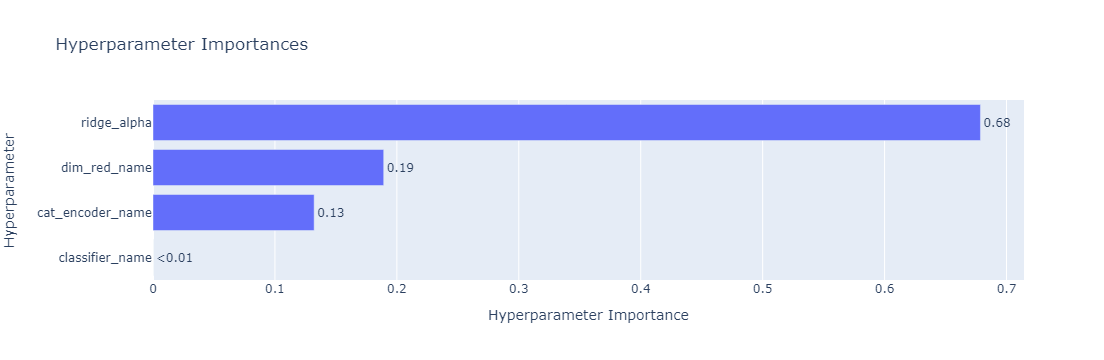

D:\Program Files2\anaconda3\Lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

D:\Program Files2\anaconda3\Lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



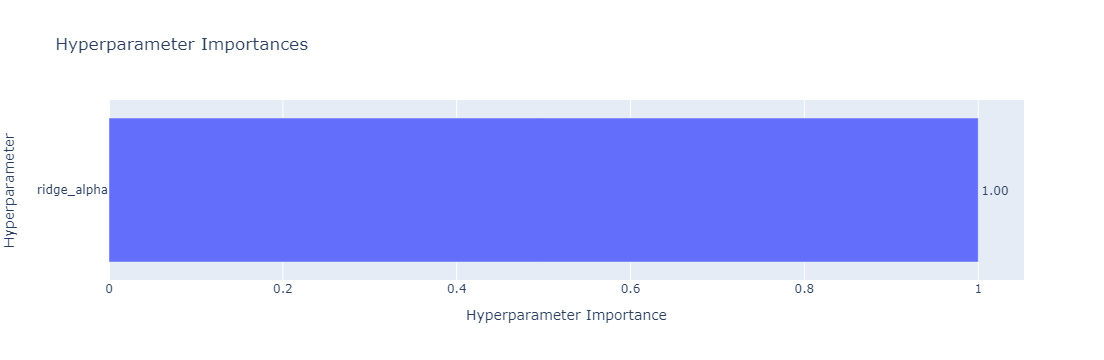

In [206]:
display(optuna.visualization.plot_param_importances(study=study_tuned_ridge))
display(optuna.visualization.plot_param_importances(study=study_tuned_ridge,params=ridge_params))

In [93]:
# Tuned Ridge pipeline for Voting Ensembler
ridge_tuned_pipe = pipeline_generator(num_variables=num_vars,cat_variables=cat_vars,feature_engineering=FeatureEngineering(),scaler_name='StandardScaler',
                                      knn_imputer_n_neighbors=4,cat_encoder_name='BinaryEncoder',
                                      dim_red_name='PCA',
                                      model_name='RidgeClassifier',
                                      dim_red_params={'n_components':0.6390750221454085},model_params={'alpha':0.24990436435068727})

In [94]:
joblib.dump(ridge_tuned_pipe,filename='ridge_tuned_pipe.joblib')

['ridge_tuned_pipe.joblib']

In [99]:
ridge_tuned_pipe.fit(X_train,y_train).score(X_test,y_test)

0.9712918660287081

#### GBM Results

In [208]:
all_params_gbc = [ col[7:] for col in study_tuned_gbm.trials_dataframe(attrs=('params','state')).columns[1:-1]]

In [209]:
gbc_params = [col for col in all_params_gbc if col.startswith('gbm')]

In [210]:
study_tuned_gbm.trials_dataframe(attrs=('value','params')).sort_values(by='value',ascending=False).drop_duplicates()

value params_cat_encoder_name      params_classifier_name  \
269  0.822692           OneHotEncoder  GradientBoostingClassifier   
246  0.821581           OneHotEncoder  GradientBoostingClassifier   
261  0.820470           OneHotEncoder  GradientBoostingClassifier   
82   0.820225           OneHotEncoder  GradientBoostingClassifier   
271  0.819346           OneHotEncoder  GradientBoostingClassifier   
..        ...                     ...                         ...   
8    0.747191           OneHotEncoder  GradientBoostingClassifier   
14   0.747191           OneHotEncoder  GradientBoostingClassifier   
9    0.739671           BinaryEncoder  GradientBoostingClassifier   
13   0.738547           BinaryEncoder  GradientBoostingClassifier   
4    0.735955           BinaryEncoder  GradientBoostingClassifier   

            params_dim_red_name  params_gbm_learning_rate  \
269                         PCA                  0.026283   
246                         PCA                  0.027847   
261                         PCA                  0.035005   
82                          PCA                  0.011471   
271                         PCA                  0.025111   
..                          ...                       ...   
8    LinearDiscriminantAnalysis                  0.060114   
14   LinearDiscriminantAnalysis                  0.025631   
9    LinearDiscriminantAnalysis                  0.182933   
13   LinearDiscriminantAnalysis                  0.166372   
4    LinearDiscriminantAnalysis                  0.139267   

     params_gbm_max_depth params_gbm_max_features  \
269                     4                    auto   
246                     4                    auto   
261                     4                    None   
82                      4                    auto   
271                     4                    auto   
..                    ...                     ...   
8                      10                    auto   
14                      9                    auto   
9                       8                    log2   
13                      8                    auto   
4                      10                    sqrt   

     params_gbm_min_samples_leaf  params_gbm_min_samples_split  \
269                           15                            16   
246                            9                            11   
261                           13                            17   
82                             4                            16   
271                           10                            16   
..                           ...                           ...   
8                             18                             2   
14                             2                             8   
9                             12                             8   
13                             2                            10   
4                              5                            15   

     params_gbm_n_estimators  params_gbm_subsample  params_pca_n_components  
269                      351              0.611072                 0.550121  
246                      312              0.621007                 0.525325  
261                      304              0.616976                 0.534269  
82                       351              0.627818                 0.521502  
271                      352              0.606840                 0.504565  
..                       ...                   ...                      ...  
8                        807              0.621386                      NaN  
14                       726              0.707480                      NaN  
9                        987              0.858151                      NaN  
13                       327              0.661490                      NaN  
4                        464              0.767668                      NaN  

[300 rows x 12 columns]

D:\Program Files2\anaconda3\Lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

D:\Program Files2\anaconda3\Lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



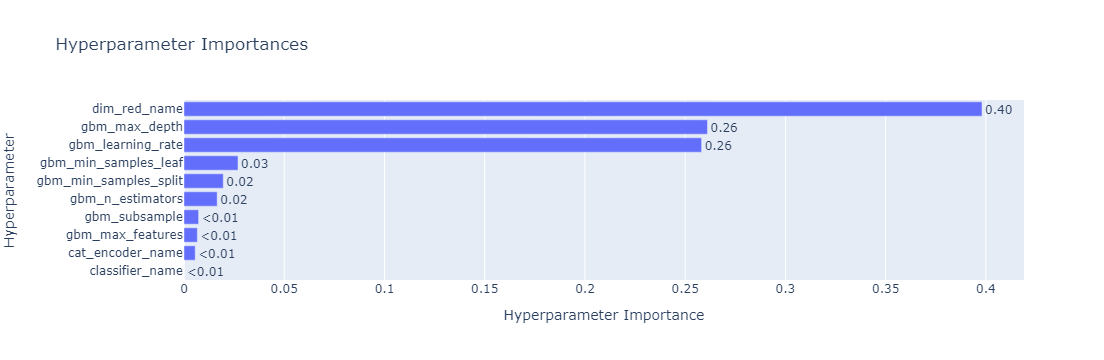

D:\Program Files2\anaconda3\Lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

D:\Program Files2\anaconda3\Lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



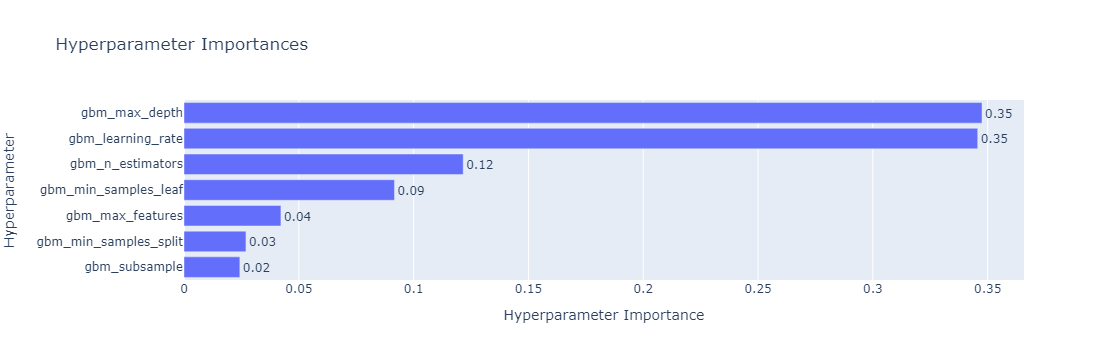

In [211]:
display(optuna.visualization.plot_param_importances(study=study_tuned_gbm))
display(optuna.visualization.plot_param_importances(study=study_tuned_gbm,params=gbc_params))

In [89]:
# Tuned GBM pipeline for Voting Ensembler
gbc_tuned_pipe = pipeline_generator(num_variables=num_vars,cat_variables=cat_vars,feature_engineering=FeatureEngineering(),scaler_name='StandardScaler',
                                      knn_imputer_n_neighbors=4,cat_encoder_name='OneHotEncoder',
                                      dim_red_name='PCA',
                                      model_name='GradientBoostingClassifier',
                                      dim_red_params={'n_components':0.5501205288504878},
                                      model_params={'n_estimators': 351,
                                                 'learning_rate': 0.026283492744532407,
                                                 'max_depth': 4,
                                                 'min_samples_split': 16,
                                                 'min_samples_leaf': 15,
                                                 'subsample': 0.6110715991484629,
                                                 'max_features': 'auto',
                                                   'random_state':42})

In [92]:
joblib.dump(gbc_tuned_pipe,filename='gbc_tuned_pipe.joblib')

['gbc_tuned_pipe.joblib']

#### SVC Results

In [212]:
all_params_svc = [ col[7:] for col in study_tuned_svc.trials_dataframe(attrs=('params','state')).columns[1:-1]]

In [213]:
svc_params = [col for col in all_params_svc if col.startswith('svc')]

In [214]:
study_tuned_svc.trials_dataframe(attrs=('value','params')).sort_values(by='value',ascending=False).drop_duplicates()

value params_cat_encoder_name params_classifier_name  \
249  0.821229           BinaryEncoder                    SVC   
221  0.821229           BinaryEncoder                    SVC   
194  0.821229           BinaryEncoder                    SVC   
189  0.821229           BinaryEncoder                    SVC   
180  0.821229           BinaryEncoder                    SVC   
..        ...                     ...                    ...   
15   0.616195           BinaryEncoder                    SVC   
76   0.616195           BinaryEncoder                    SVC   
16   0.616195           BinaryEncoder                    SVC   
2    0.616195           OneHotEncoder                    SVC   
77   0.616195           BinaryEncoder                    SVC   

            params_dim_red_name  params_pca_n_components  params_svc_C  \
249                         PCA                 0.641435     21.969127   
221                         PCA                 0.615346     15.487478   
194                         PCA                 0.658427     20.719449   
189                         PCA                 0.930231     20.820118   
180                         PCA                 0.917099     33.893900   
..                          ...                      ...           ...   
15   LinearDiscriminantAnalysis                      NaN      3.154199   
76   LinearDiscriminantAnalysis                      NaN     30.350141   
16                          PCA                 0.808944      0.974303   
2    LinearDiscriminantAnalysis                      NaN    128.510773   
77   LinearDiscriminantAnalysis                      NaN     34.976836   

     params_svc_degree  params_svc_gamma params_svc_kernel  
249                NaN          0.015408               rbf  
221                NaN          0.018593               rbf  
194                NaN          0.017410               rbf  
189                NaN          0.017545               rbf  
180                NaN          0.012718               rbf  
..                 ...               ...               ...  
15                 5.0          0.000004              poly  
76                 4.0          0.000444              poly  
16                 NaN          0.000058           sigmoid  
2                  4.0          0.000058              poly  
77                 4.0          0.002278              poly  

[250 rows x 9 columns]

D:\Program Files2\anaconda3\Lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

D:\Program Files2\anaconda3\Lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



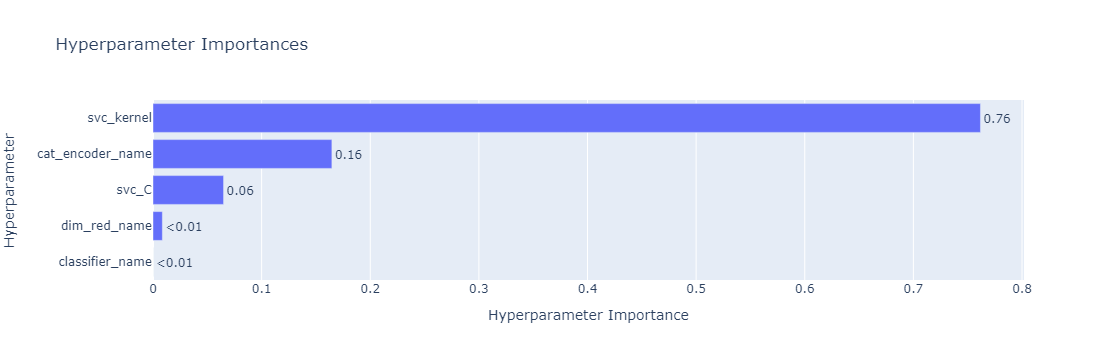

D:\Program Files2\anaconda3\Lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

D:\Program Files2\anaconda3\Lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



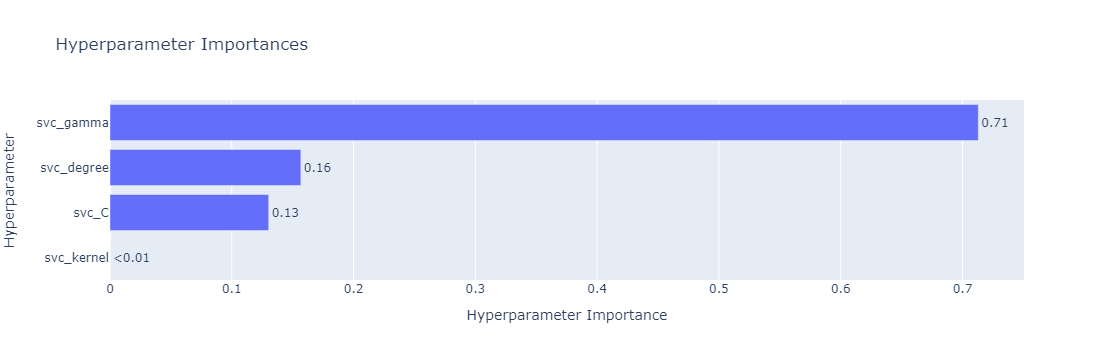

In [216]:
display(optuna.visualization.plot_param_importances(study=study_tuned_svc))
display(optuna.visualization.plot_param_importances(study=study_tuned_svc,params=svc_params))

In [272]:
study_tuned_svc.best_params

{'cat_encoder_name': 'BinaryEncoder',
 'dim_red_name': 'PCA',
 'pca_n_components': 0.918571174542757,
 'classifier_name': 'SVC',
 'svc_C': 12.559514924350328,
 'svc_kernel': 'rbf',
 'svc_gamma': 0.021818414412590068}

In [95]:
# Tuned SVC pipeline for Voting Ensembler
svc_tuned_pipe = pipeline_generator(num_variables=num_vars,cat_variables=cat_vars,
                                      knn_imputer_n_neighbors=4,cat_encoder_name='BinaryEncoder',
                                      dim_red_name='PCA',
                                      model_name='SVC',
                                      dim_red_params={'n_components':0.918571174542757},
                                      model_params={'C': 12.559514924350328,
                                                 'kernel': 'rbf',
                                                 'gamma': 0.021818414412590068})

In [96]:
joblib.dump(svc_tuned_pipe,filename='svc_tuned_pipe.joblib')

['svc_tuned_pipe.joblib']

### Final Model => Voting Classifier

In [97]:
ensemble_classifier = VotingClassifier(
   [('ridge_tuned',ridge_tuned_pipe),
    ('gbc_tuned',gbc_tuned_pipe),
    ('svc_tuned',svc_tuned_pipe)],voting='hard')

In [98]:
joblib.dump(ensemble_classifier,filename='ensemble_classifier.joblib')

['ensemble_classifier.joblib']




Test Score with 
              precision    recall  f1-score   support

           0       0.98      0.94      0.96       266
           1       0.91      0.97      0.94       152

    accuracy                           0.95       418
   macro avg       0.94      0.96      0.95       418
weighted avg       0.95      0.95      0.95       418

Total Fit Time (Train):0.7259049415588379 second
Total Predict Time(Test):0.06250309944152832 second


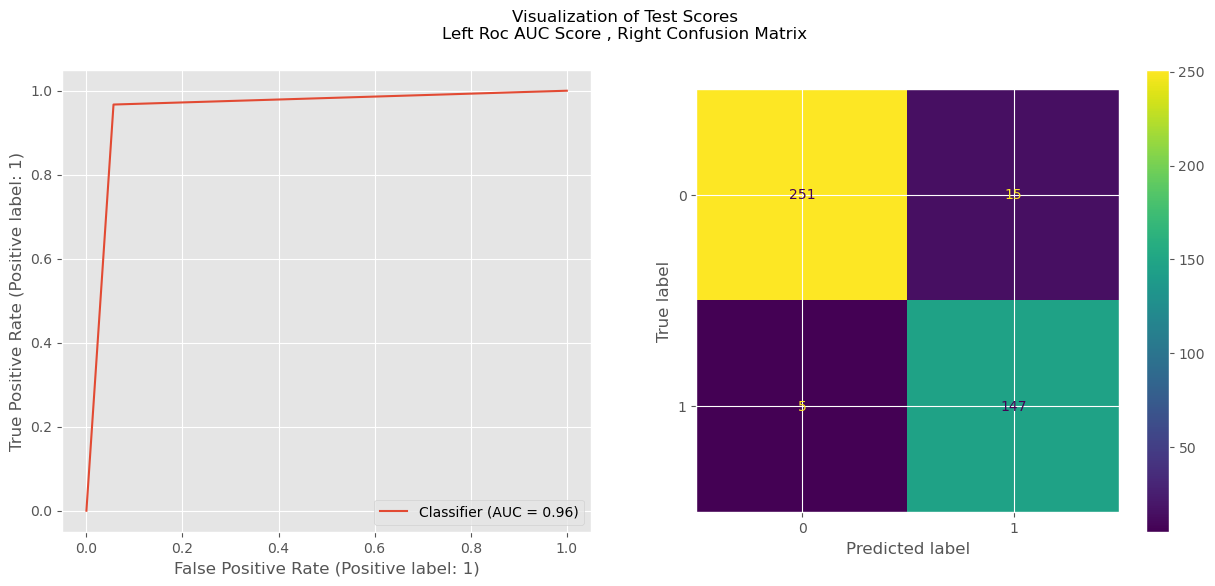




Train Score with 
              precision    recall  f1-score   support

           0       0.85      0.90      0.87       549
           1       0.82      0.75      0.78       342

    accuracy                           0.84       891
   macro avg       0.84      0.82      0.83       891
weighted avg       0.84      0.84      0.84       891

Total Fit Time (Train):0.7259049415588379 second
Total Predict Time(Test):0.13453102111816406 second


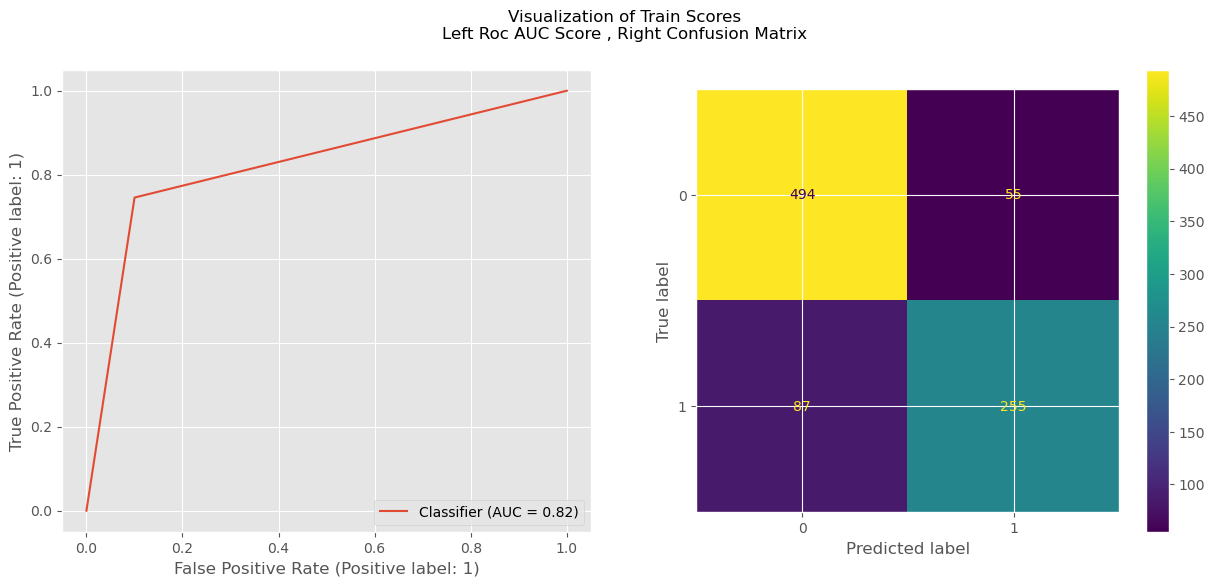

In [72]:
model_metrics_clf(model=ensemble_classifier)

# Conclusion

Firstly i chose my base models and transformers (Scalers,Dimensionality Reduction algorithms vs.) as below (according to score of all models):

    - Cat encoder => Binary,One hot 

    - Classifier => RidgeClf , SVC , GBM

    - DimRed => PCA , LinearDiscriminantAnalysis

    - params_knn_imp_n_neighbors => 4

    - params_bTransformer_name => 'passthrough'

    - scaler => StandardScaler

Then i applied hyper-parameter optimization on classifier models. Scores are below:

    - Ridge => 0.9712918660287081

    - GBC => 0.8947368421052632

    - SVC => 0.9473684210526315

Then I ensemble these 3 models. But actually GBC should be left out. Because its score difference with others is really high and it affected VotingClassifiers score. But I kept it for diversity.

In this problem, the desired metric is accuracy, so I mostly looked at it. 

<mark> My final model gave %95 test accuracy score and %84 train accuracy score.

Note: I didn't drop or manipulate the outliers.This step can be added in pipeline